### Appendix 4

Our task is to build a model that will sample several check-in dates in order to give a valuable prediction of the discount price for any given check-in date.

The task's success will be determined by the R^2 of the discount prices in the database to the predicted ones.

Start by loading the data and going through it:

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
df = pd.read_csv(r'C:\Users\Ariel\Desktop\Hotels_data_Changed.csv', header=0)
df.head()

Unnamed: 0  Snapshot ID Snapshot Date Checkin Date  Days  Original Price  \
0           0            1    2015-07-17   2015-08-12     5            1178   
1           1            1    2015-07-17   2015-08-19     5            1113   
2           2            1    2015-07-17   2015-08-13     5            4370   
3           3            1    2015-07-17   2015-07-26     5            1739   
4           4            1    2015-07-17   2015-08-12     5            1739   

   Discount Price  Discount Code  Available Rooms  \
0            1040              1                6   
1             982              1                8   
2            4240              1                3   
3            1667              1               18   
4            1672              1                3   

                               Hotel Name  Hotel Stars  DayDiff  WeekDay  \
0  Best Western Plus Seaport Inn Downtown            3       26        2   
1  Best Western Plus Seaport Inn Downtown            3       33        2   
2                  The Peninsula New York            5       27        3   
3            Eventi Hotel a Kimpton Hotel            4        9        6   
4            Eventi Hotel a Kimpton Hotel            4       26        2   

   DiscountDiff  DiscountPerc  
0           138     11.714771  
1           131     11.769991  
2           130      2.974828  
3            72      4.140311  
4            67      3.852789

Making the columns date-friendly

In [2]:
df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
df['Snapshot Date'] = pd.to_datetime(df['Snapshot Date'])

Let's check how many different values we have in the 3 columns - Hotel Name, Discount Code and Snapshot Date:

In [289]:
print("Hotel Name unique values:", df['Hotel Name'].nunique())
print("Discount Code unique values:", df['Discount Code'].nunique())
print("Snapshot Date unique values:", df['Snapshot Date'].nunique())

Hotel Name unique values: 554
Discount Code unique values: 4
Snapshot Date unique values: 151


We have 4 discount prices, 554 hotels and 151 snapshot dates, hence the total options will be 4 times 554 times 151 = 334616. Therefore, for a full dataset we should have 334616*30 = ~10 Million rows. Let's see the database size:

In [290]:
df.shape

(187848, 15)

It looks like the data is very sparse and missing many rows that can give an accurate prediction, so our method will be to understand the data that we do have in the best possible way, and then fine-tune it to get the most accurate predictions for any input.

Let's start deriving information from the data, and learning about it.

Are there any null values?

In [291]:
#tdf = df.copy(deep = True)
df.isnull().sum().sort_values(ascending=False)

DiscountPerc       0
DiscountDiff       0
WeekDay            0
DayDiff            0
Hotel Stars        0
Hotel Name         0
Available Rooms    0
Discount Code      0
Discount Price     0
Original Price     0
Days               0
Checkin Date       0
Snapshot Date      0
Snapshot ID        0
Unnamed: 0         0
dtype: int64

Wait, are there any lines where snap date is after checkin date?

In [4]:
print ((df['Snapshot Date'] > df['Checkin Date']).sum())

0


There aren't any of those, we are good to go.

#### Learning about the data
Some examples of a tuple of (hotel,snap date, discount id):

In [293]:
df.loc[(df['Hotel Name'] == 'Grand Hyatt New York')
      & (df['Checkin Date'] >= datetime(2015,9,1)) & (df['Checkin Date'] <= datetime(2015,9,30))
      & (df['Discount Code'] == 1) & (df['Snapshot Date'] == datetime(2015,9,1))]

Unnamed: 0  Snapshot ID Snapshot Date Checkin Date  Days  \
25079       25079          188    2015-09-01   2015-09-07     5   
25080       25080          188    2015-09-01   2015-09-20     5   
25081       25081          188    2015-09-01   2015-09-23     5   

       Original Price  Discount Price  Discount Code  Available Rooms  \
25079            2135            2055              1               97   
25080            2435            2175              1              186   
25081            2915            2815              1              186   

                 Hotel Name  Hotel Stars  DayDiff  WeekDay  DiscountDiff  \
25079  Grand Hyatt New York            4        6        0            80   
25080  Grand Hyatt New York            4       19        6           260   
25081  Grand Hyatt New York            4       22        2           100   

       DiscountPerc  
25079      3.747073  
25080     10.677618  
25081      3.430532

In [294]:
df.loc[(df['Hotel Name'] == 'Hilton Garden Inn New York West 35th Street')
      & (df['Checkin Date'] >= datetime(2015,10,1)) & (df['Checkin Date'] <= datetime(2015,10,31))
      & (df['Discount Code'] == 4) & (df['Snapshot Date'] == datetime(2015,10,1))]

Unnamed: 0  Snapshot ID Snapshot Date Checkin Date  Days  \
69559       69559          428    2015-10-01   2015-10-02     5   
69560       69560          428    2015-10-01   2015-10-09     5   

       Original Price  Discount Price  Discount Code  Available Rooms  \
69559            1845            1473              4               -1   
69560            1841            1699              4               -1   

                                        Hotel Name  Hotel Stars  DayDiff  \
69559  Hilton Garden Inn New York West 35th Street            3        1   
69560  Hilton Garden Inn New York West 35th Street            3        8   

       WeekDay  DiscountDiff  DiscountPerc  
69559        4           372     20.162602  
69560        4           142      7.713199

In [295]:
df.loc[(df['Hotel Name'] == 'Renaissance Newark Airport Hotel')
      & (df['Checkin Date'] >= datetime(2015,11,15)) & (df['Checkin Date'] <= datetime(2015,12,14))
      & (df['Discount Code'] == 3) & (df['Snapshot Date'] == datetime(2015,11,15))]

Unnamed: 0  Snapshot ID Snapshot Date Checkin Date  Days  \
135198      135198          518    2015-11-15   2015-11-26     5   
135199      135199          518    2015-11-15   2015-11-30     5   
135200      135200          518    2015-11-15   2015-12-01     5   
135201      135201          518    2015-11-15   2015-12-02     5   
135202      135202          518    2015-11-15   2015-12-03     5   
135203      135203          518    2015-11-15   2015-12-07     5   
135204      135204          518    2015-11-15   2015-12-08     5   
135205      135205          518    2015-11-15   2015-12-09     5   
135206      135206          518    2015-11-15   2015-12-10     5   
135207      135207          518    2015-11-15   2015-12-14     5   

        Original Price  Discount Price  Discount Code  Available Rooms  \
135198            1050             824              3                5   
135199            1093             924              3                5   
135200            1084             898              3                5   
135201            1041             889              3                5   
135202            1058             796              3                5   
135203            1110             914              3                5   
135204            1101             897              3                5   
135205            1050             888              3                5   
135206            1050             752              3                5   
135207            1092             905              3                5   

                              Hotel Name  Hotel Stars  DayDiff  WeekDay  \
135198  Renaissance Newark Airport Hotel            4       11        3   
135199  Renaissance Newark Airport Hotel            4       15        0   
135200  Renaissance Newark Airport Hotel            4       16        1   
135201  Renaissance Newark Airport Hotel            4       17        2   
135202  Renaissance Newark Airport Hotel            4       18        3   
135203  Renaissance Newark Airport Hotel            4       22        0   
135204  Renaissance Newark Airport Hotel            4       23        1   
135205  Renaissance Newark Airport Hotel            4       24        2   
135206  Renaissance Newark Airport Hotel            4       25        3   
135207  Renaissance Newark Airport Hotel            4       29        0   

        DiscountDiff  DiscountPerc  
135198           226     21.523810  
135199           169     15.462031  
135200           186     17.158672  
135201           152     14.601345  
135202           262     24.763705  
135203           196     17.657658  
135204           204     18.528610  
135205           162     15.428571  
135206           298     28.380952  
135207           187     17.124542

Some interesing observations so far: 
* The data does indeed look very sparse, as we suspected earlier.
* One might argue the data is also somewhat noisy, looking at the differences between the discount percentages.
* The discount rates are not always very distinguishable, but it does looks like there are some different factors that affect the discount being given.
* In the first tuple we sampled, the DiscountDiff are rounded number, where in the other it's not. That suggest some hotels choose the discount by a percentage and some by a fixed number. But it's still not enough to determine.

Let's see how our columns are build, by their mean, standard deviation and quartiles

In [296]:
df.describe()

Unnamed: 0    Snapshot ID      Days  Original Price  Discount Price  \
count  187848.000000  187848.000000  187848.0   187848.000000   187848.000000   
mean    93923.500000     351.643451       5.0     1825.742143     1673.172283   
std     54227.191021    1007.348927       0.0     1042.355712      983.618013   
min         0.000000       1.000000       5.0      289.000000      260.000000   
25%     46961.750000     150.000000       5.0     1160.000000     1035.000000   
50%     93923.500000     439.000000       5.0     1599.000000     1475.000000   
75%    140885.250000     506.000000       5.0     2160.000000     1963.250000   
max    187847.000000  417419.000000       5.0    29975.000000    28675.000000   

       Discount Code  Available Rooms    Hotel Stars        DayDiff  \
count  187848.000000    187848.000000  187848.000000  187848.000000   
mean        2.434186        14.588561       3.905823      17.465685   
std         1.005191        41.575482       0.846496      10.040225   
min         1.000000        -1.000000       0.000000       1.000000   
25%         2.000000        -1.000000       3.000000       9.000000   
50%         2.000000        -1.000000       4.000000      18.000000   
75%         3.000000         8.000000       4.000000      26.000000   
max         4.000000       431.000000       5.000000      34.000000   

             WeekDay   DiscountDiff   DiscountPerc  
count  187848.000000  187848.000000  187848.000000  
mean        2.917763     152.569860       8.877715  
std         1.840536     143.316985       6.030248  
min         0.000000      15.000000       0.581395  
25%         2.000000      70.000000       4.844961  
50%         3.000000     103.000000       7.056229  
75%         4.000000     180.000000      10.933941  
max         6.000000    3760.000000      68.425842

We can see that Original and Discount Prices columns range between very large values (almost 30k). But also that these values are very rare as the upper quartile is just about ~2000. Most hotels fall between the $1000-2000 mark.

We don't have a lot of information about the available rooms, but even when we do, most of them are no more than double digit. Hotel Stars are below average (3).

We have unnecessary data - DayDiff max is above 30, our task's threshold. We'll decide what to do with that later.

DiscountDiff is usually around $150, and the lower and upper quartile indicate that although it is the median (which a std deviation of ~140), most hotels don't give more than 180 USD discount. To understand how significant these discount are, we take a look at the DiscountPerc:

For the discount percentages, it seems that the average discount is only 8 percent with a std of 6. Also, 75% of the rows in the list have no more than 11 percent on the Original Price. This suggests there aren't various approaches when setting the discount as most hotels decide on the same range of discounts.

Unnamed is just the # of the row, Snapshot ID is the snapshot #, and Days column seems to always be 5, Let's remove them. We will also copy the data in case we'll need it later.

In [5]:
data = df.copy()
data.drop(['Unnamed: 0','Snapshot ID','Days'],axis = 1,inplace = True)

Before we continue to explore the data, we will want to see how the data behaves in general. Since the goal of this task is to predict the discount price, the best way to look at this will be to see the discount percantages the hotels give, since that combined with the original price will yield the desired discount price.

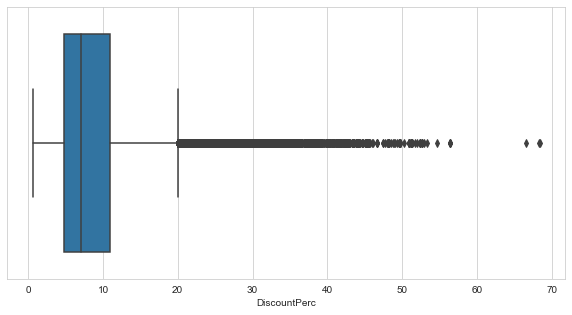

In [298]:
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
sns.boxplot(data['DiscountPerc'])

In [299]:
data.loc[data['DiscountPerc'] > 20].shape

(10923, 12)

There are almost 11k rows that the 1.5IQR rule detecs as outliers, but that's 5 percent of our data, and it comes from many hotels (including those which we have the most information about). therefore we will not touch these rows right now.
It may refer to special discount by these hotels.

Overall, most of the discounts are not very high (As we saw earlier when we described the data)

In [302]:
print(data.loc[data['DiscountPerc'] > 20]['Hotel Name'].value_counts().head())
print ('# of hotels with an average of 20% and above:',data.loc[data['DiscountPerc'] > 20]['Hotel Name'].nunique())

Newark Liberty International Airport Marriott                   2232
Residence Inn Newark Elizabeth Liberty International Airport    1683
Renaissance Newark Airport Hotel                                 795
DoubleTree by Hilton Metropolitan - New York City                333
Hilton Garden Inn Times Square                                   316
Name: Hotel Name, dtype: int64
# of hotels with an average of 20% and above: 176


Checking the 3 rows which exceed 60% discount.

In [304]:
data.loc[data['DiscountPerc'] > 60]

Snapshot Date Checkin Date  Original Price  Discount Price  \
26262    2015-09-02   2015-09-03            5495            1735   
68905    2015-10-01   2015-10-20            3274            1093   
69313    2015-10-01   2015-10-22            3193            1012   

       Discount Code  Available Rooms                              Hotel Name  \
26262              1                2  Hyatt Place Flushing LaGuardia Airport   
68905              2                1         Manhattan Broadway Budget Hotel   
69313              3                1         Manhattan Broadway Budget Hotel   

       Hotel Stars  DayDiff  WeekDay  DiscountDiff  DiscountPerc  
26262            3        1        3          3760     68.425842  
68905            2       19        1          2181     66.615761  
69313            2       21        3          2181     68.305669

In [305]:
data.loc[(data['Hotel Name'] == 'Manhattan Broadway Budget Hotel') & (data['Snapshot Date'] == datetime(2015,10,1))]

Snapshot Date Checkin Date  Original Price  Discount Price  \
68905    2015-10-01   2015-10-20            3274            1093   
69313    2015-10-01   2015-10-22            3193            1012   

       Discount Code  Available Rooms                       Hotel Name  \
68905              2                1  Manhattan Broadway Budget Hotel   
69313              3                1  Manhattan Broadway Budget Hotel   

       Hotel Stars  DayDiff  WeekDay  DiscountDiff  DiscountPerc  
68905            2       19        1          2181     66.615761  
69313            2       21        3          2181     68.305669

In [307]:
data.loc[(data['Hotel Name'] == 'Manhattan Broadway Budget Hotel')].head()

Snapshot Date Checkin Date  Original Price  Discount Price  \
21056    2015-08-29   2015-09-26            2379            1147   
36811    2015-07-26   2015-08-23             653             580   
37180    2015-07-26   2015-08-17             797             742   
37587    2015-07-26   2015-08-19             734             679   
37588    2015-07-26   2015-08-20             707             652   

       Discount Code  Available Rooms                       Hotel Name  \
21056              2                3  Manhattan Broadway Budget Hotel   
36811              1                7  Manhattan Broadway Budget Hotel   
37180              2               10  Manhattan Broadway Budget Hotel   
37587              3                7  Manhattan Broadway Budget Hotel   
37588              3                7  Manhattan Broadway Budget Hotel   

       Hotel Stars  DayDiff  WeekDay  DiscountDiff  DiscountPerc  
21056            2       28        5          1232     51.786465  
36811            2       28        6            73     11.179173  
37180            2       22        0            55      6.900878  
37587            2       24        2            55      7.493188  
37588            2       25        3            55      7.779349

In [308]:
data.loc[(data['Hotel Name'] == 'Hyatt Place Flushing LaGuardia Airport') & (data['Snapshot Date'] == datetime(2015,9,2))]

Snapshot Date Checkin Date  Original Price  Discount Price  \
26262    2015-09-02   2015-09-03            5495            1735   
26263    2015-09-02   2015-10-03            1895            1495   
26513    2015-09-02   2015-09-03            5495            3425   
26514    2015-09-02   2015-10-02            1895            1595   
26515    2015-09-02   2015-10-03            1895            1595   
26855    2015-09-02   2015-09-07            1285            1230   

       Discount Code  Available Rooms                              Hotel Name  \
26262              1                2  Hyatt Place Flushing LaGuardia Airport   
26263              1               10  Hyatt Place Flushing LaGuardia Airport   
26513              2                2  Hyatt Place Flushing LaGuardia Airport   
26514              2               10  Hyatt Place Flushing LaGuardia Airport   
26515              2               10  Hyatt Place Flushing LaGuardia Airport   
26855              3                3  Hyatt Place Flushing LaGuardia Airport   

       Hotel Stars  DayDiff  WeekDay  DiscountDiff  DiscountPerc  
26262            3        1        3          3760     68.425842  
26263            3       31        5           400     21.108179  
26513            3        1        3          2070     37.670610  
26514            3       30        4           300     15.831135  
26515            3       31        5           300     15.831135  
26855            3        5        0            55      4.280156

In [309]:
data.loc[(data['Hotel Name'] == 'Hyatt Place Flushing LaGuardia Airport')]['Original Price'].value_counts()

1285    53
1230    30
1927    24
1895    18
1375    13
939     12
1090    11
1145    11
1745     8
869      8
1245     8
2475     7
900      6
1948     6
1969     6
1295     5
1240     5
1495     5
1420     4
945      4
1507     2
5495     2
1170     1
680      1
1335     1
806      1
1185     1
1045     1
896      1
1380     1
Name: Original Price, dtype: int64

In [310]:
data.loc[(data['Hotel Name'] == 'Hyatt Place Flushing LaGuardia Airport')]['DiscountPerc'].mean()

13.109094004263516

Even though the discounts are big for these 3 specific rows, from the above calculation per each of these two hotels it seems it's not likely to be a mistake.

Let's plot some histograms and see the way how some of the current features are scattered

Text(0, 0.5, '# of rows')

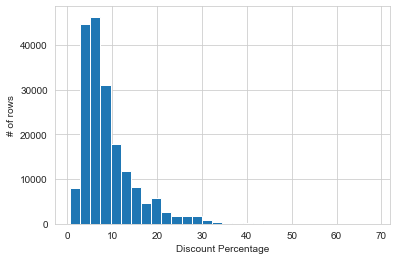

In [311]:
plt.hist(data['DiscountPerc'],bins=30)
plt.xlabel('Discount Percentage')
plt.ylabel('# of rows')

Like we thought, most of the discounts are <20, but there is still a nice amount of discounts above 20 percent

Text(0, 0.5, '# of rows')

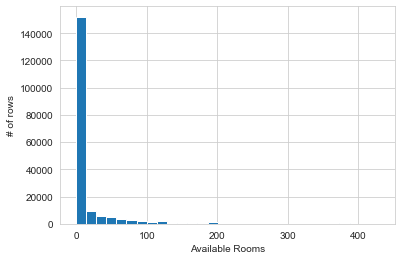

In [312]:
plt.hist(data['Available Rooms'],bins=30)
plt.xlabel('Available Rooms')
plt.ylabel('# of rows')

In [313]:
data['Available Rooms'].value_counts().sort_index()

-1      101664
 1       10627
 2        5590
 3        4444
 4        3310
 5       10875
 6        1882
 7        1975
 8        1754
 9        2103
 10       4220
 11       1579
 12       1179
 13        946
 14       1116
 15       1289
 16        618
 17        586
 18        781
 19        627
 20        897
 21        595
 22        580
 23        504
 24        388
 25        534
 26        355
 27        412
 28        527
 29        359
         ...  
 365        16
 366        10
 367        33
 368         5
 369         4
 370        12
 371        10
 372        22
 373        29
 374        58
 375        53
 376        52
 377        51
 378        39
 379        30
 380        83
 381        22
 382        21
 383        17
 415         4
 416        18
 418         7
 419         6
 421         6
 422         3
 423        12
 424         2
 425         6
 430         6
 431        11
Name: Available Rooms, Length: 321, dtype: int64

More than 50% of the available rooms for each row are missing. this might be a problem. we'll keep that in mind for now.

Text(0, 0.5, '# of rows')

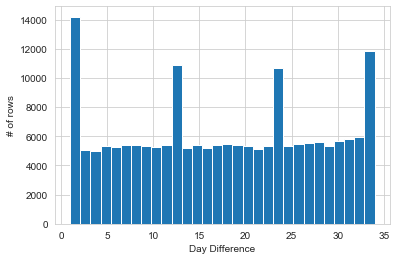

In [314]:
plt.hist(data['DayDiff'],bins=30)
plt.xlabel('Day Difference')
plt.ylabel('# of rows')

A large amount of data is above 30-31 days difference (which is above what we need in this task), but it shouldn't matter.But we will keep that in mind once we try to optimize the model.

Working with dates is hard. we will start by splitting it to year-month-day separately and adding the week number of each date:

In [6]:
data['Snap_year'] = data['Snapshot Date'].dt.year
data['Snap_month'] = data['Snapshot Date'].dt.month
data['Snap_day'] = data['Snapshot Date'].dt.day
data['Snap_week'] = data['Snapshot Date'].dt.week

data['Checkin_year'] = data['Checkin Date'].dt.year
data['Checkin_month'] = data['Checkin Date'].dt.month
data['Checkin_day'] = data['Checkin Date'].dt.day
data['Checkin_week'] = data['Checkin Date'].dt.week

In [316]:
print(data.groupby(data['Snap_year']).size())
print("----")
print(data.groupby(data['Snap_month']).size())
print("----")
print(data.groupby(data['Snap_day']).size())
print("----")
print(data.groupby(data['Snap_week']).size())
print("----")

print(data.groupby(data['Checkin_year']).size())
print("----")
print(data.groupby(data['Checkin_month']).size())
print("----")
print(data.groupby(data['Checkin_day']).size())
print("----")
print(data.groupby(data['Checkin_week']).size())

print("----")
print(data.groupby(data['DayDiff']).size())

Snap_year
2015    186915
2016       933
dtype: int64
----
Snap_month
1       933
7     18596
8     36068
9     29526
10    45034
11    34203
12    23488
dtype: int64
----
Snap_day
1     4734
2     5401
3     4525
4     5567
5     5235
6     5609
7     4901
8     4959
9     4899
10    6123
11    6133
12    6064
13    4344
14    5648
15    5929
16    6228
17    7141
18    7168
19    7105
20    7426
21    7377
22    7229
23    8417
24    5858
25    6132
26    7282
27    7405
28    6117
29    7489
30    5971
31    3432
dtype: int64
----
Snap_week
29     3275
30    10230
31     6383
32     8363
33     8016
34     8566
35     8682
36     6257
37     7156
38     7697
39     7120
40     9136
41    10659
42     9950
43     9646
44     9446
45     9840
46     7604
47     8652
48     6749
50     4536
51     7912
52     7188
53     4785
dtype: int64
----
Checkin_year
2015    173540
2016     14308
dtype: int64
----
Checkin_month
1     13924
2       384
7      3542
8     30398
9     31327
10    3922

Example from the data with the new features

In [318]:
data.loc[(data['Hotel Name'] == 'Park Hyatt New York') &
       (data['Snapshot Date'] == datetime(2015,7,20)) &
       (data['Discount Code'] == 1) ].head()

Snapshot Date Checkin Date  Original Price  Discount Price  \
177848    2015-07-20   2015-07-24            3900            3750   
177849    2015-07-20   2015-07-25            3900            3750   
177850    2015-07-20   2015-07-27            3900            3750   
177851    2015-07-20   2015-07-28            3900            3750   
177852    2015-07-20   2015-07-29            3900            3750   

        Discount Code  Available Rooms           Hotel Name  Hotel Stars  \
177848              1                7  Park Hyatt New York            5   
177849              1                7  Park Hyatt New York            5   
177850              1                7  Park Hyatt New York            5   
177851              1                7  Park Hyatt New York            5   
177852              1                9  Park Hyatt New York            5   

        DayDiff  WeekDay  DiscountDiff  DiscountPerc  Snap_year  Snap_month  \
177848        4        4           150      3.846154       2015           7   
177849        5        5           150      3.846154       2015           7   
177850        7        0           150      3.846154       2015           7   
177851        8        1           150      3.846154       2015           7   
177852        9        2           150      3.846154       2015           7   

        Snap_day  Snap_week  Checkin_year  Checkin_month  Checkin_day  \
177848        20         30          2015              7           24   
177849        20         30          2015              7           25   
177850        20         30          2015              7           27   
177851        20         30          2015              7           28   
177852        20         30          2015              7           29   

        Checkin_week  
177848            30  
177849            30  
177850            31  
177851            31  
177852            31

The year feature doesn't seem so informative. There are only two options, and the vast majority of them are from 2015 so they're redundant. Let's remove them.

In [7]:
data['Snap_year'].value_counts(ascending=False)

2015    186915
2016       933
Name: Snap_year, dtype: int64

In [8]:
data['Checkin_year'].value_counts(ascending=False)

2015    173540
2016     14308
Name: Checkin_year, dtype: int64

In [9]:
data.drop(['Snap_year','Checkin_year'],axis=1,inplace= True)

After seeing some interesting things about some of the data, it's time to understand the relations between all the features and their correlation to one another:

Pairplot:

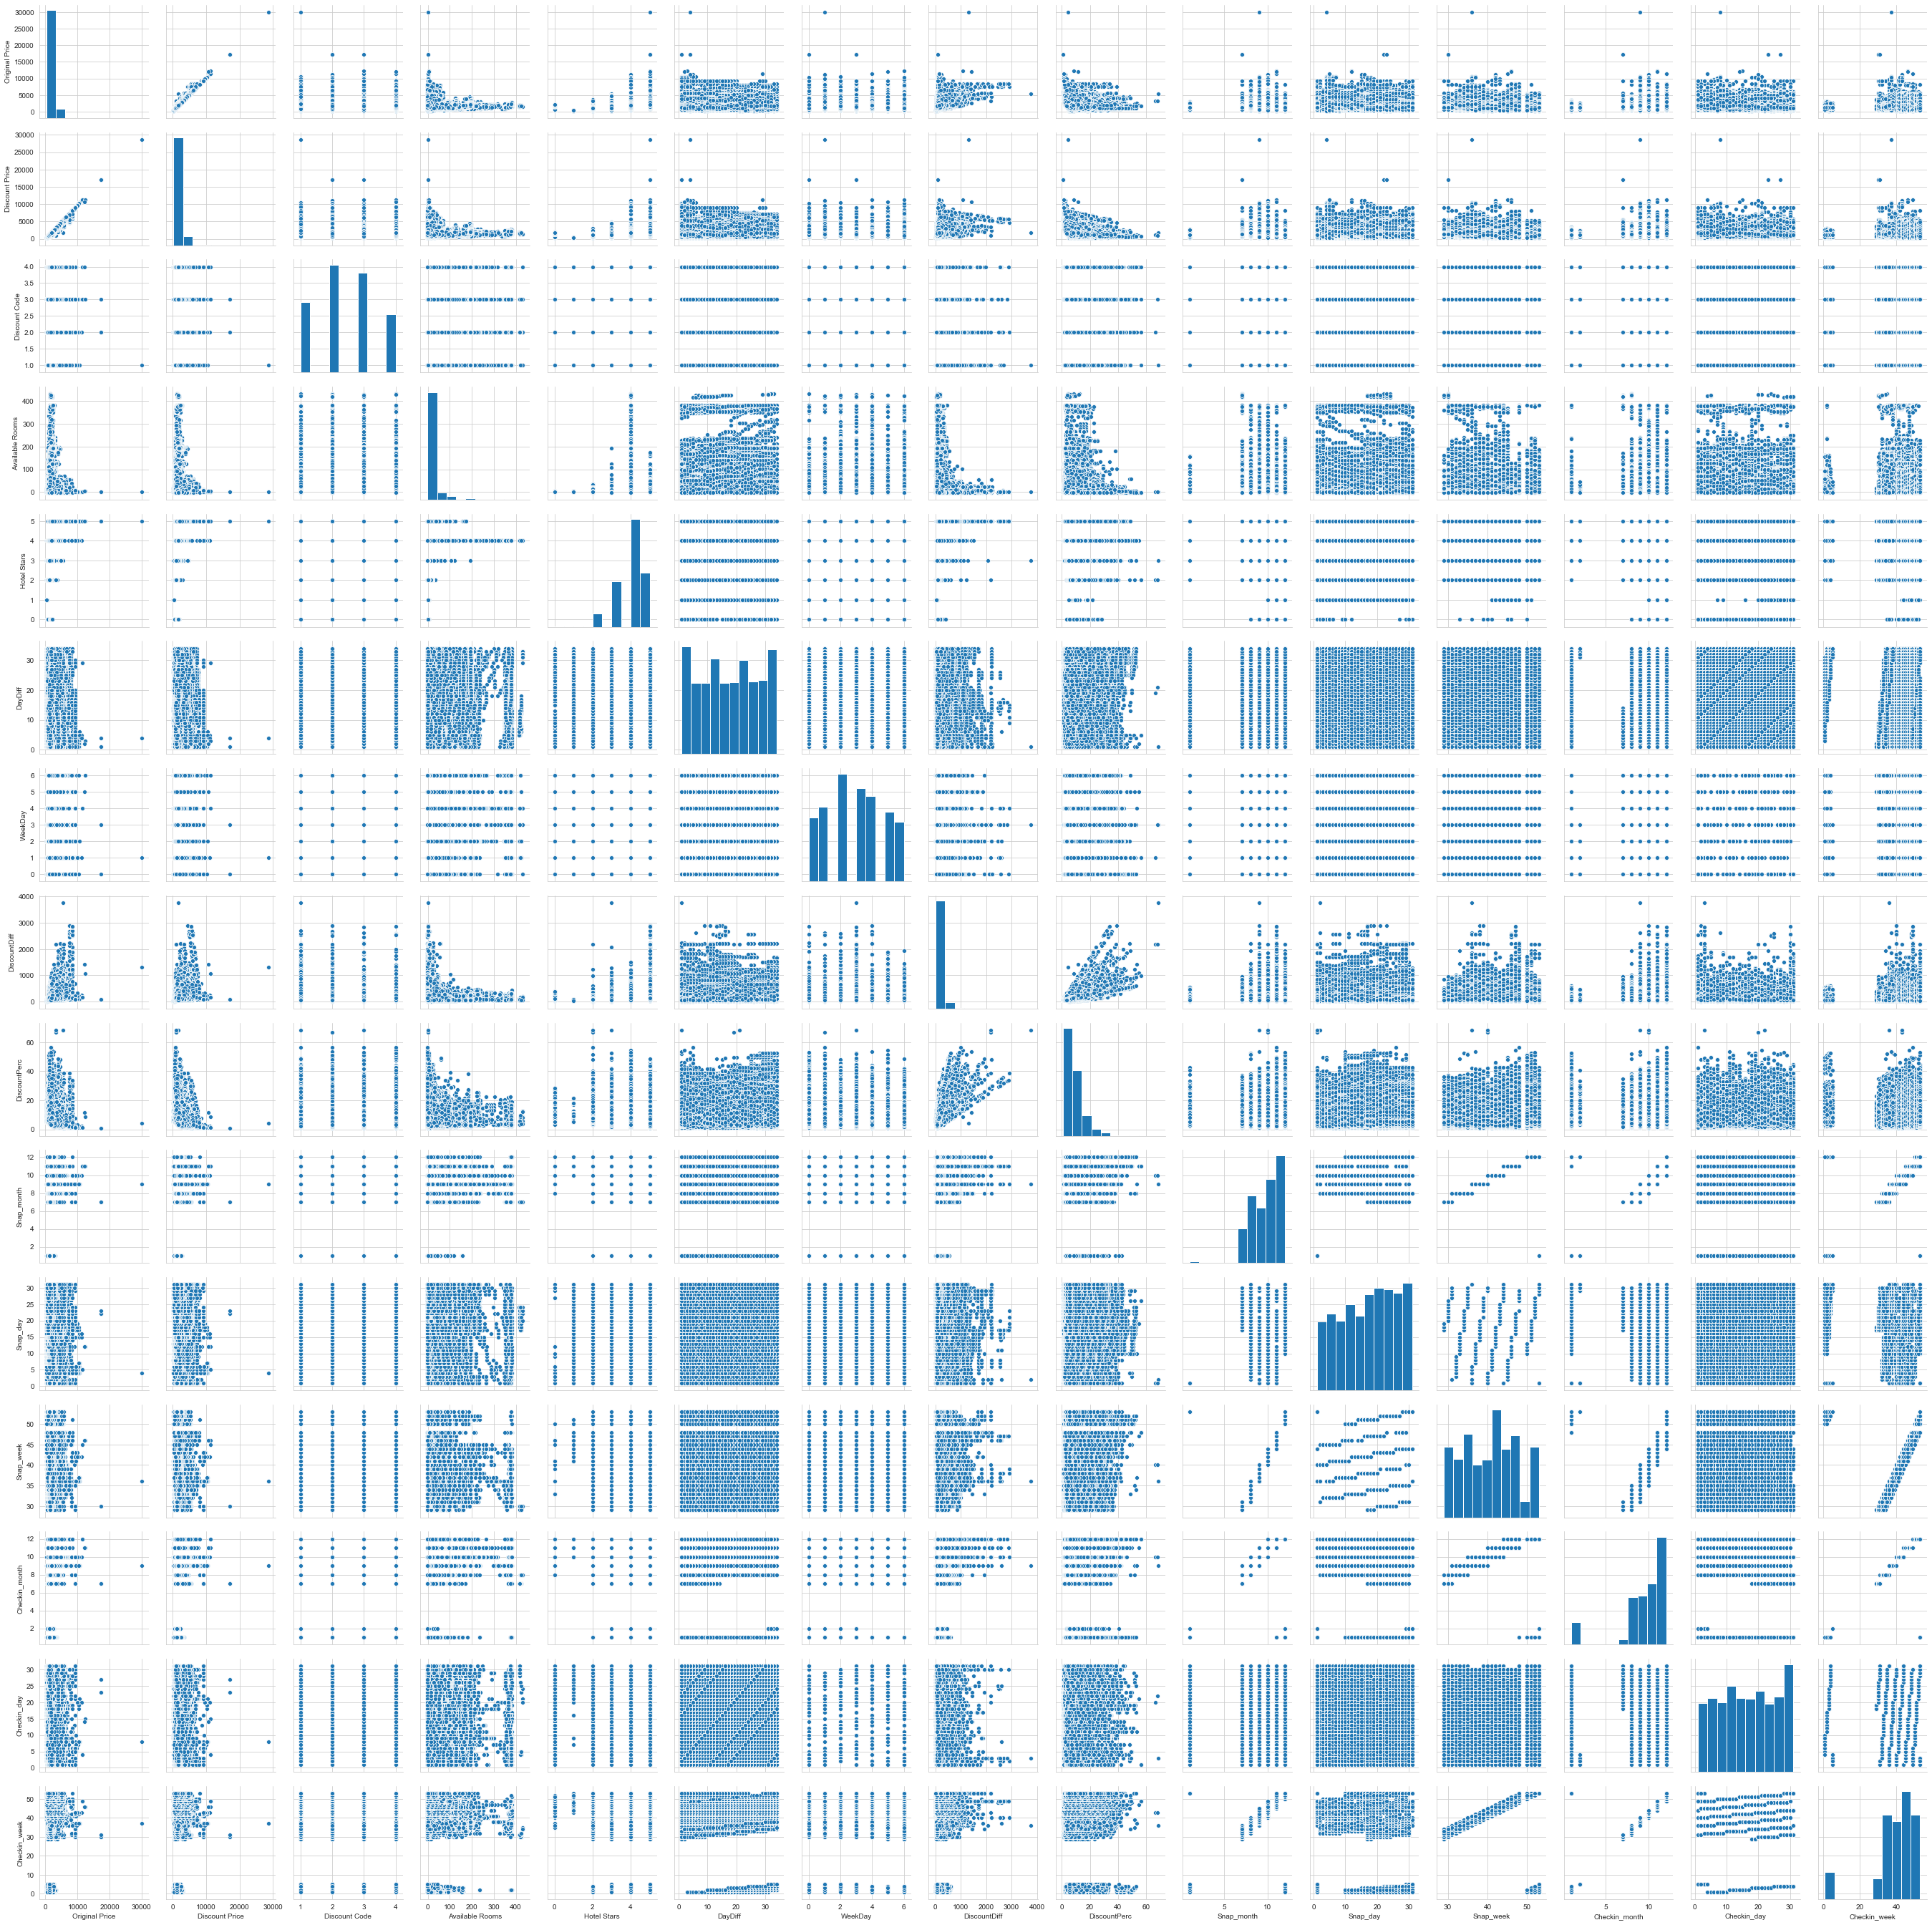

In [322]:
import seaborn as sns
sns.set_style('whitegrid')
sns.pairplot(data)

Correlation matrix:

In [323]:
data.corr()

Original Price  Discount Price  Discount Code  \
Original Price         1.000000        0.991666       0.018161   
Discount Price         0.991666        1.000000       0.023251   
Discount Code          0.018161        0.023251       1.000000   
Available Rooms        0.072001        0.079803       0.001815   
Hotel Stars            0.593265        0.586073       0.032960   
DayDiff                0.045914        0.048442       0.032362   
WeekDay               -0.043718       -0.043653      -0.135500   
DiscountDiff           0.467044        0.349230      -0.027490   
DiscountPerc          -0.151366       -0.258325      -0.036223   
Snap_month            -0.086974       -0.096905       0.005913   
Snap_day              -0.036619       -0.039295      -0.005993   
Snap_week             -0.120785       -0.133484       0.004876   
Checkin_month          0.128175        0.137555       0.008167   
Checkin_day           -0.046040       -0.046604      -0.007976   
Checkin_week           0.102453        0.110763      -0.000498   

                 Available Rooms  Hotel Stars   DayDiff   WeekDay  \
Original Price          0.072001     0.593265  0.045914 -0.043718   
Discount Price          0.079803     0.586073  0.048442 -0.043653   
Discount Code           0.001815     0.032960  0.032362 -0.135500   
Available Rooms         1.000000     0.123910  0.032711 -0.003947   
Hotel Stars             0.123910     1.000000  0.037201 -0.066471   
DayDiff                 0.032711     0.037201  1.000000 -0.012305   
WeekDay                -0.003947    -0.066471 -0.012305  1.000000   
DiscountDiff           -0.024043     0.292513  0.001465 -0.018365   
DiscountPerc           -0.092789    -0.090960 -0.018199 -0.014893   
Snap_month             -0.020135    -0.011463 -0.047676 -0.016671   
Snap_day               -0.022185     0.026396 -0.004444 -0.012440   
Snap_week              -0.031792    -0.000998 -0.047454 -0.023052   
Checkin_month           0.032602    -0.039008 -0.067240  0.012012   
Checkin_day            -0.023710    -0.018924 -0.021392  0.006707   
Checkin_week            0.024505    -0.038055 -0.086237  0.031133   

                 DiscountDiff  DiscountPerc  Snap_month  Snap_day  Snap_week  \
Original Price       0.467044     -0.151366   -0.086974 -0.036619  -0.120785   
Discount Price       0.349230     -0.258325   -0.096905 -0.039295  -0.133484   
Discount Code       -0.027490     -0.036223    0.005913 -0.005993   0.004876   
Available Rooms     -0.024043     -0.092789   -0.020135 -0.022185  -0.031792   
Hotel Stars          0.292513     -0.090960   -0.011463  0.026396  -0.000998   
DayDiff              0.001465     -0.018199   -0.047676 -0.004444  -0.047454   
WeekDay             -0.018365     -0.014893   -0.016671 -0.012440  -0.023052   
DiscountDiff         1.000000      0.672048    0.032511  0.003354   0.037655   
DiscountPerc         0.672048      1.000000    0.136033  0.023963   0.172691   
Snap_month           0.032511      0.136033    1.000000 -0.051809   0.857832   
Snap_day             0.003354      0.023963   -0.051809  1.000000   0.054398   
Snap_week            0.037655      0.172691    0.857832  0.054398   1.000000   
Checkin_month       -0.011852     -0.141098    0.120979 -0.143696  -0.011815   
Checkin_day         -0.014996      0.006253    0.057487  0.097896   0.071727   
Checkin_week        -0.015047     -0.128238    0.174581 -0.118942   0.053395   

                 Checkin_month  Checkin_day  Checkin_week  
Original Price        0.128175    -0.046040      0.102453  
Discount Price        0.137555    -0.046604      0.110763  
Discount Code         0.008167    -0.007976     -0.000498  
Available Rooms       0.032602    -0.023710      0.024505  
Hotel Stars          -0.039008    -0.018924     -0.038055  
DayDiff              -0.067240    -0.021392     -0.086237  
WeekDay               0.012012     0.006707      0.031133  
DiscountDiff         -0.011852    -0.014996     -0.015047  
DiscountPerc         -0.141098    

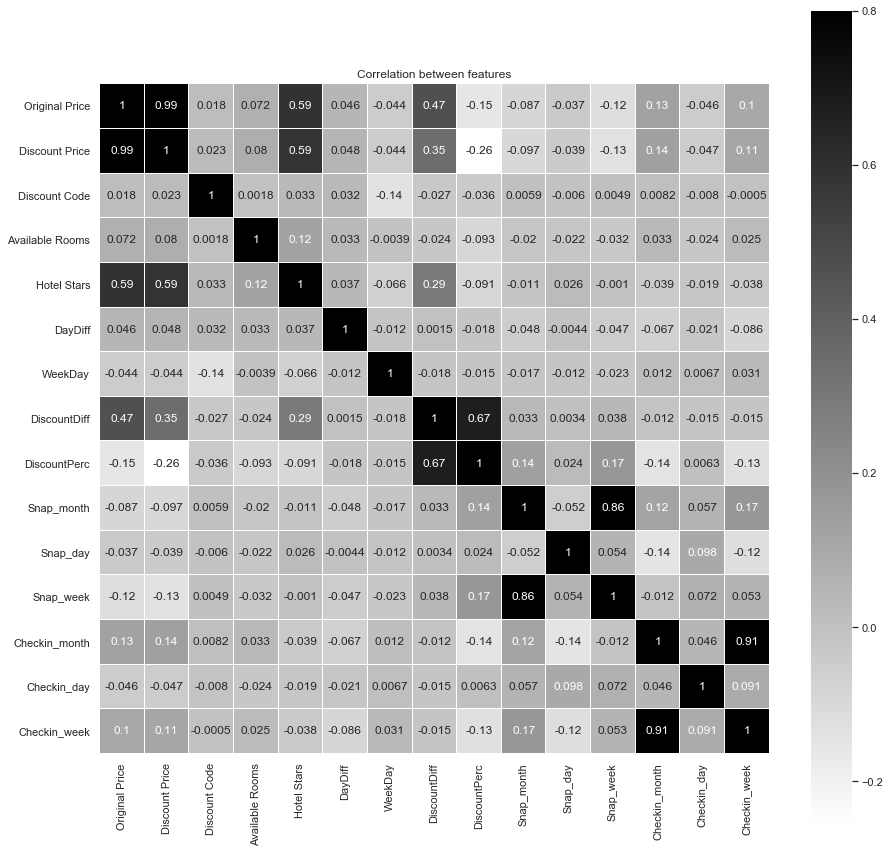

In [324]:
corrMatrix=data.corr()

sns.set(font_scale=1)
plt.figure(figsize=(15, 15))

ax = sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='binary',linecolor="white")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation between features');

There's a very strong correlation between the Original Price of the hotel to the Discount price, suggesting the discounts are usually in the same range for all hotels (except maybe some outliers or special ocassions).

After that, the most informative features seem to be the Hotel Stars and the DayDiff. We are still unsure about the Available Rooms feature because it has a lot of missing data, but we might get good information out of it if we try to do some mean calculation of the free rooms per hotel on each of the missing date.

The check-in month and week are also decent correlators.
The snapshot month and week, and the WeekDay features has a negative correlation to the price. They do have a positive correlation to the discount percentage, as excepted (the more the percetange, the lower the price)

Everything we saw in the correlation matrix can also be seen in the pairplot we printed. Strong linear correlation between the Original Price and the Discount Price, something that looks like a -log function with the Available Rooms, some increase when the Hotel Stars increase, and some differences in terms of highs and lows with as a function of the DayDiff feature. This can be seem both in regards to the Discount Price and the DiscountPerc

If it's hard to tell from the giant graph, we printed some of them individually:

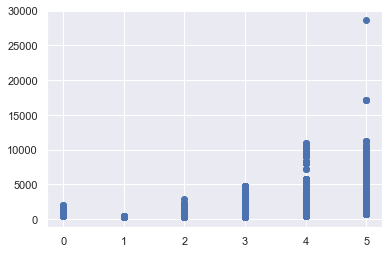

In [325]:
plt.scatter(data['Hotel Stars'],data['Discount Price'])

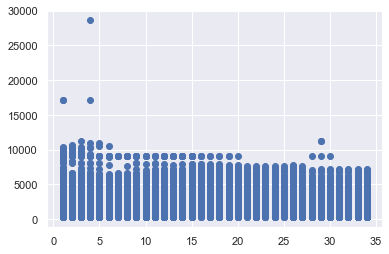

In [326]:
plt.scatter(data['DayDiff'],data['Discount Price'])

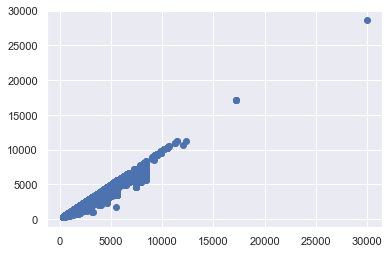

In [327]:
plt.scatter(data['Original Price'],data['Discount Price'])

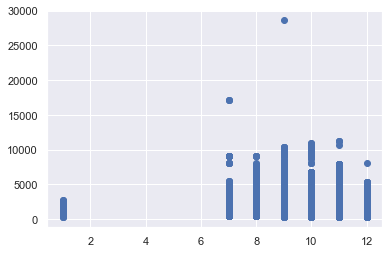

In [328]:
plt.scatter(data['Snap_month'],data['Discount Price'])

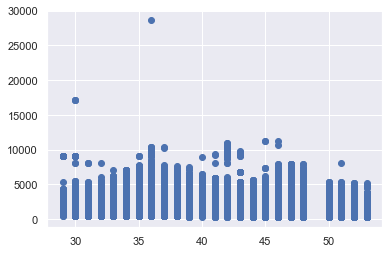

In [329]:
plt.scatter(data['Snap_week'],data['Discount Price'])

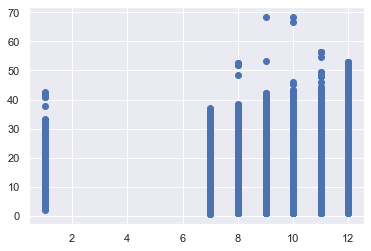

In [330]:
plt.scatter(data['Snap_month'],data['DiscountPerc'])

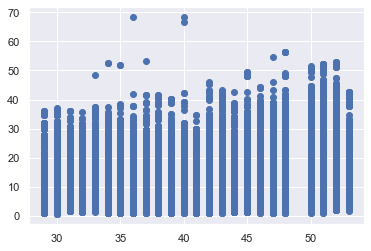

In [331]:
plt.scatter(data['Snap_week'],data['DiscountPerc'])

### Learning about the tuple Snapshot Date, Discount Code and Hotel Name
The 3 features that lead this task might give us insightful observations about the data needed for this task. We will start with them. 

#### Snapshot Date (and Check-in date)

Two primary things that may alter the prices are the Snapshot date and the Check-in date. We want to see if we can learn anything by looking at the columns' average:

In [332]:
data.groupby(['Snapshot Date']).mean()

Original Price  Discount Price  Discount Code  Available Rooms  \
Snapshot Date                                                                   
2015-07-17        1789.014085     1668.398122       2.422535         9.773709   
2015-07-18        1795.523132     1674.008007       2.438612        10.029359   
2015-07-19        1817.569982     1694.174954       2.417127        10.215470   
2015-07-20        1809.504699     1686.318609       2.400376        10.526316   
2015-07-21        1757.669414     1629.945055       2.412088        10.184066   
2015-07-22        1845.832515     1717.755695       2.413131        11.118356   
2015-07-23        1732.758653     1605.263330       2.377923        11.356876   
2015-07-24        1830.203098     1698.873494       2.439759        12.196213   
2015-07-25        1645.886838     1497.030498       2.413323        11.573034   
2015-07-26        1645.628394     1497.734678       2.425136        11.607448   
2015-07-27        1641.515128     1494.059736       2.419705        12.301009   
2015-07-28        1712.514907     1564.020145       2.428687        12.673650   
2015-07-29        1696.069630     1549.432593       2.452593        12.167407   
2015-07-30        1616.472337     1475.167630       2.414533        15.988439   
2015-08-02        1682.350619     1545.905573       2.436533        17.140093   
2015-08-03        1701.189020     1566.174902       2.436078        15.643137   
2015-08-04        1694.102729     1556.788925       2.443820        17.448636   
2015-08-05        1748.027160     1611.136626       2.423045        17.835391   
2015-08-06        1749.664768     1610.279902       2.449146        17.949552   
2015-08-07        1677.372432     1544.720890       2.451199        17.394692   
2015-08-08        1769.841915     1625.143631       2.468835        16.031617   
2015-08-09        1830.251113     1685.004452       2.466607        17.558326   
2015-08-10        1818.305813     1668.860994       2.486099        15.160910   
2015-08-11        1748.944805     1607.149351       2.413149        14.742695   
2015-08-12        1723.074883     1566.069423       2.431357        15.801872   
2015-08-13        1877.860360     1735.886261       2.467342        37.316441   
2015-08-14        1821.935157     1685.720365       2.403242        26.635258   
2015-08-15        1798.140249     1655.029046       2.442324        22.128631   
2015-08-16        1815.570040     1673.646154       2.418623        24.546559   
2015-08-17        1826.556297     1683.584654       2.410342        26.311093   
...                       ...             ...            ...              ...   
2015-11-21        1597.767530     1443.559451       2.475610        10.027439   
2015-11-22        1661.707589     1506.378720       2.467262        10.770089   
2015-11-23        1658.054795     1504.771918       2.469863        10.669178   
2015-11-26        1690.311129     1531.620634       2.476848        13.613323   
2015-11-27        1699.913669     1539.697042       2.462830        13.061551   
2015-11-28        1659.857883     1489.536640       2.460400        12.210955   
2015-11-29        1681.006868     1508.821429       2.447115        11.328984   
2015-12-10        1562.640557     1392.708442       2.396867         9.295039   
2015-12-11        1543.368020     1375.969543       2.423012         9.020305   
2015-12-12        1520.315881     1351.086387       2.419721        10.628272   
2015-12-13        1506.116147     1336.190746       2.423041         9.769594   
2015-12-14        1541.354561     1372.481067       2.406196        10.271945   
2015-12-15        1571.542783     1396.637857       2.439931        10.721694   
2015-12-16        1578.323077     1404.185470       2.455556         9.445299   
2015-12-17        1520.996383     1346.933996       2.426763         9.161844   
2015-12-18        1493.480804     1318.734004       2.434186         9.598720   
2015-12-19        1425.382705     1253.810488 

Discount Percent as a factor of the Snapshot date:

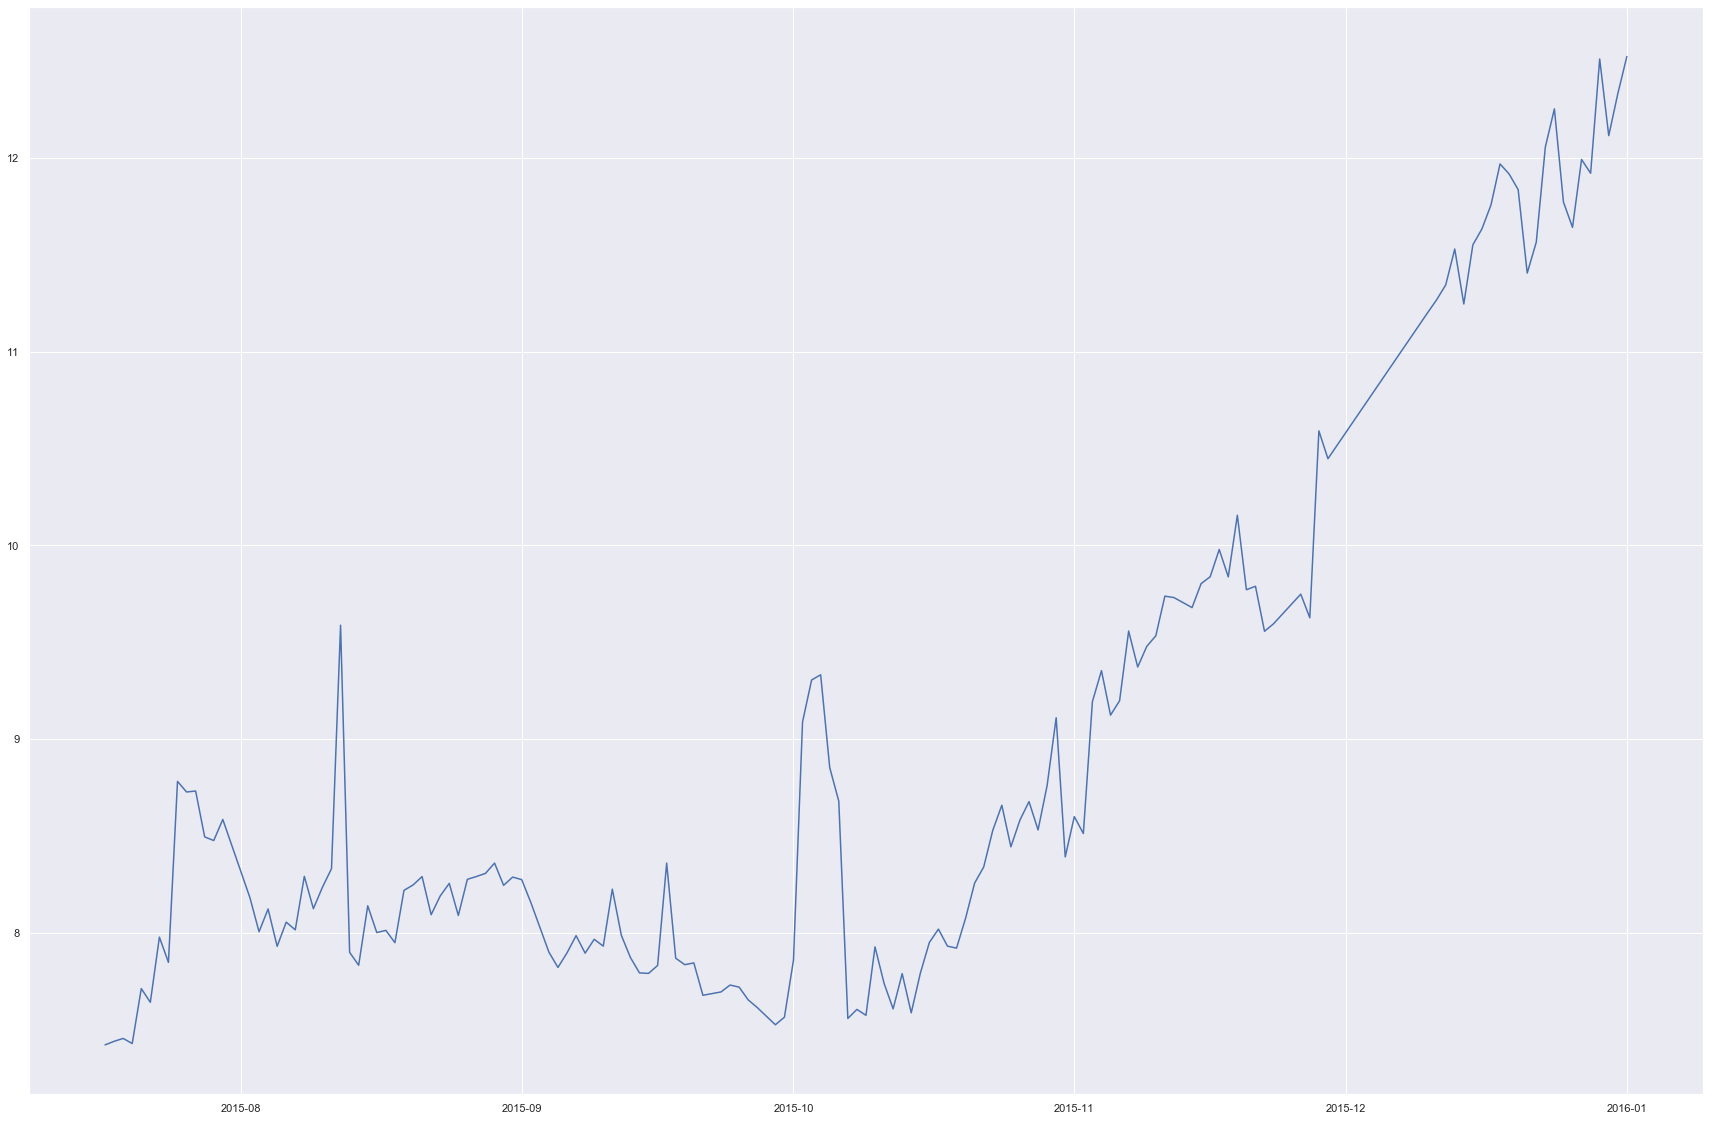

In [333]:
plt.figure(figsize=(30,20))
plt.plot(data.groupby(['Snapshot Date']).mean().index,data.groupby(['Snapshot Date']).mean()['DiscountPerc'])

Discount Price (mean) as a factor of the Snapshot date:

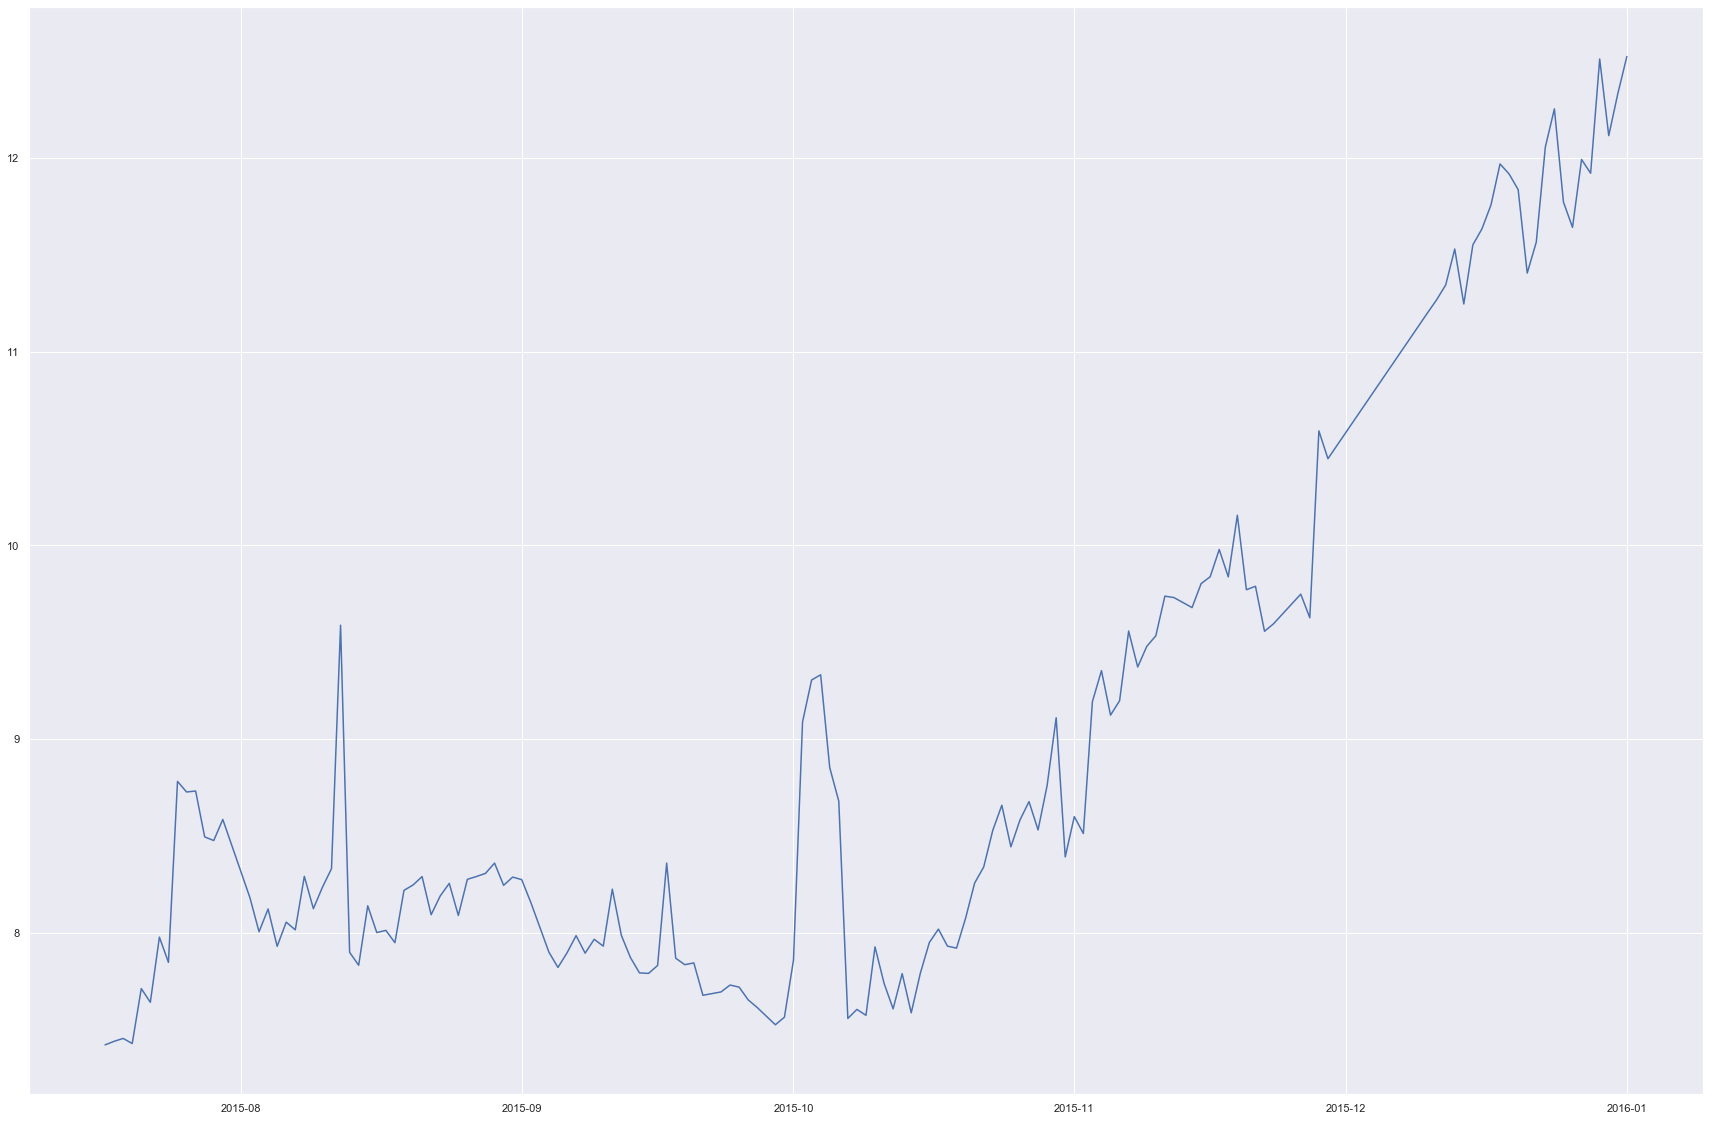

In [334]:
plt.figure(figsize=(30,20))
plt.plot(df.groupby(['Snapshot Date']).mean().index,df.groupby(['Snapshot Date']).mean()['DiscountPerc'])

From mid-July to mid-October, the graph of the discount percentage is somewhat flat with a slight decrease, then from mid-October it begins to rise until the end of the year. That's an insightful observation that might affect our model. we wil decide later if to accommodate that by adding features or dividing the data into 2 chunks. The exact date to slice is the 14/10 (inclusive).

This observation is in line with what we saw and understood earlier.

There are also 2 big spikes in the DiscountPerc graph that look like a special day/sale/holiday (Remeber, we are looking at the discount as the snapshot date- date of order). Let's check that:

In [335]:
data.groupby(['Snapshot Date']).mean().loc[data.groupby(['Snapshot Date']).mean()['DiscountPerc'] > 9].head()

Original Price  Discount Price  Discount Code  Available Rooms  \
Snapshot Date                                                                   
2015-08-12        1723.074883     1566.069423       2.431357        15.801872   
2015-10-02        1948.908873     1787.366906       2.440647        10.245803   
2015-10-03        1897.929825     1743.172043       2.442558         9.696661   
2015-10-04        1914.474860     1756.831386       2.484510         9.909599   
2015-10-30        1668.959677     1522.465543       2.449413        14.746334   

               Hotel Stars    DayDiff   WeekDay  DiscountDiff  DiscountPerc  \
Snapshot Date                                                                 
2015-08-12        3.666927  18.801092  3.535881    157.005460      9.588445   
2015-10-02        3.747002  20.485012  2.859712    161.541966      9.089153   
2015-10-03        3.659310  20.872100  2.586304    154.757782      9.305605   
2015-10-04        3.655663  19.540884  2.884205    157.643474      9.332618   
2015-10-30        3.889296  17.400293  3.145894    146.494135      9.110882   

               Snap_month  Snap_day  Snap_week  Checkin_month  Checkin_day  \
Snapshot Date                                                                
2015-08-12            8.0      12.0       33.0       8.441498    17.114665   
2015-10-02           10.0       2.0       40.0      10.251199    14.697842   
2015-10-03           10.0       3.0       40.0      10.357668    12.784380   
2015-10-04           10.0       4.0       40.0      10.266125    15.291011   
2015-10-30           10.0      30.0       44.0      11.023460    15.751466   

               Checkin_week  
Snapshot Date                
2015-08-12        35.466459  
2015-10-02        43.089329  
2015-10-03        43.326542  
2015-10-04        43.236668  
2015-10-30        46.607771

The dates are the 12nd of August and 2-4th of October. According to the 2015 calendar there weren't any big US holidays on these dates. However we will add them to the data and see later on if we can get something out of it.

In [10]:
data['isAugust12'] = (data['Snapshot Date'] ==  datetime(2015,8,12)).astype(int)
data['isOctober2-4'] = (data['Snapshot Date'] >=  datetime(2015,10,2)) & (data['Snapshot Date'] <=  datetime(2015,10,4))
data['isOctober2-4'] = data['isOctober2-4'].astype(int)

In [345]:
data.head()

Snapshot Date Checkin Date  Original Price  Discount Price  Discount Code  \
0    2015-07-17   2015-08-12            1178            1040              1   
1    2015-07-17   2015-08-19            1113             982              1   
2    2015-07-17   2015-08-13            4370            4240              1   
3    2015-07-17   2015-07-26            1739            1667              1   
4    2015-07-17   2015-08-12            1739            1672              1   

   Available Rooms                              Hotel Name  Hotel Stars  \
0                6  Best Western Plus Seaport Inn Downtown            3   
1                8  Best Western Plus Seaport Inn Downtown            3   
2                3                  The Peninsula New York            5   
3               18            Eventi Hotel a Kimpton Hotel            4   
4                3            Eventi Hotel a Kimpton Hotel            4   

   DayDiff  WeekDay  DiscountDiff  DiscountPerc  Snap_month  Snap_day  \
0       26        2           138     11.714771           7        17   
1       33        2           131     11.769991           7        17   
2       27        3           130      2.974828           7        17   
3        9        6            72      4.140311           7        17   
4       26        2            67      3.852789           7        17   

   Snap_week  Checkin_month  Checkin_day  Checkin_week  isAugust12  \
0         29              8           12            33           0   
1         29              8           19            34           0   
2         29              8           13            33           0   
3         29              7           26            30           0   
4         29              8           12            33           0   

   isOctober2-4  
0             0  
1             0  
2             0  
3             0  
4             0

Let's move to see the same plots for the Check-in date

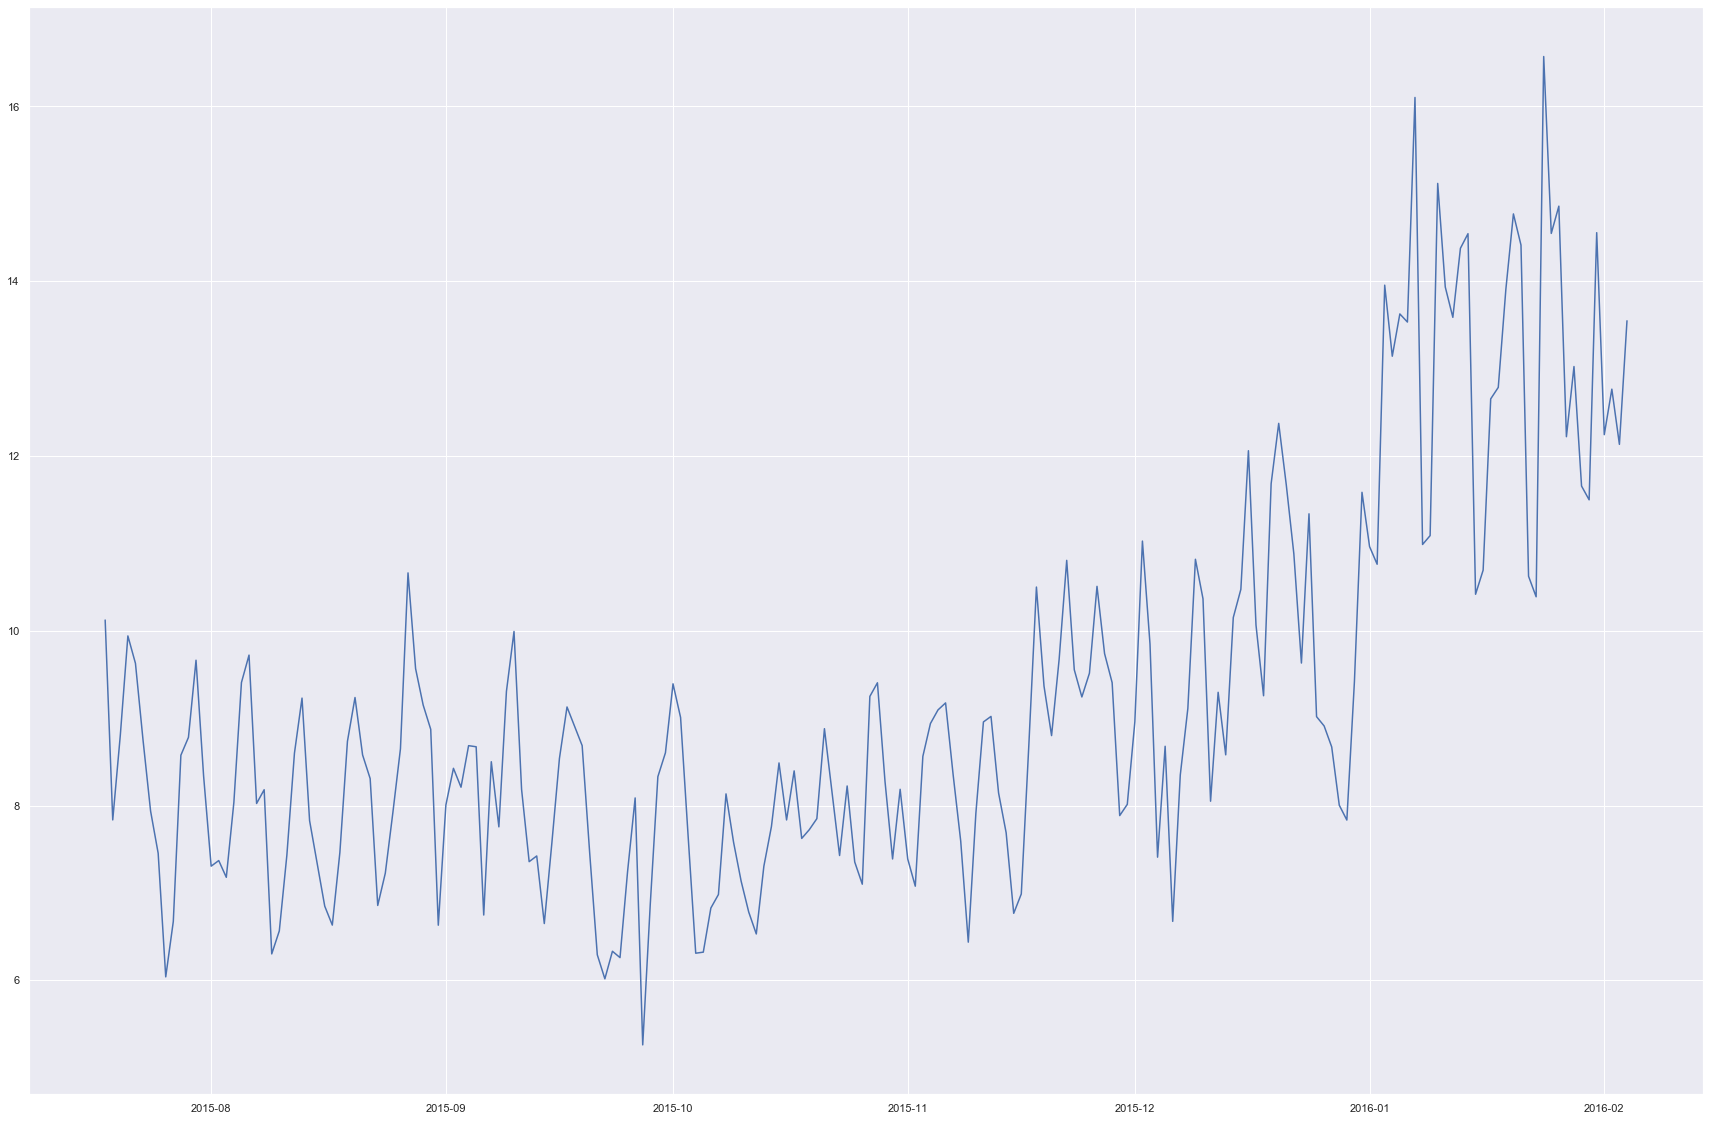

In [346]:
plt.figure(figsize=(30,20))
plt.plot(data.groupby(['Checkin Date']).mean().index,data.groupby(['Checkin Date']).mean()['DiscountPerc'])

Same behavior but with way more spikes, this hinders some cyclicality behavior. Probably the day of the week.

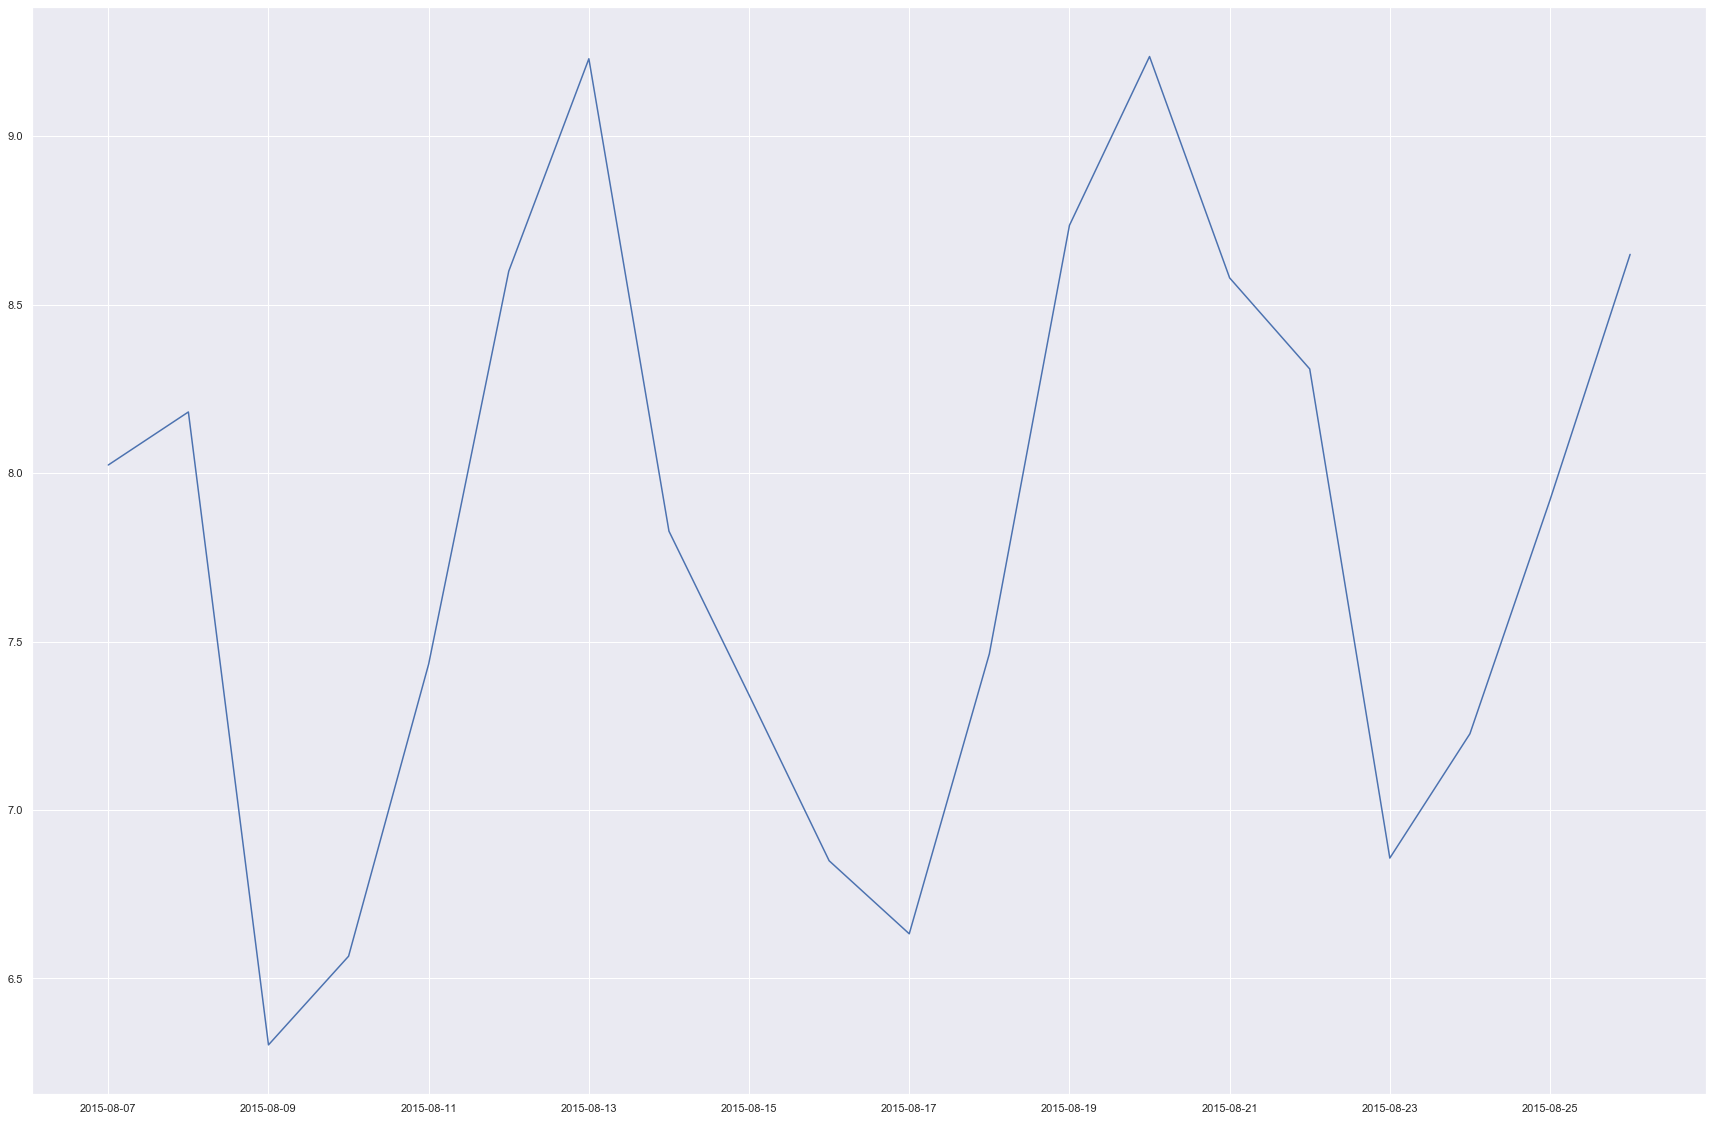

In [347]:
plt.figure(figsize=(30,20))
plt.plot(data.groupby(['Checkin Date']).mean()[20:40].index,data.groupby(['Checkin Date']).mean()[20:40]['DiscountPerc'])

It does indeed looks like the WeekDay feature cause these "spikes". Let's finish with learning about it a bit more.

In [348]:
data.groupby(['WeekDay']).mean()

Original Price  Discount Price  Discount Code  Available Rooms  \
WeekDay                                                                   
0           1877.373911     1737.888136       2.671969        14.219302   
1           1923.384207     1768.066925       2.577538        14.644820   
2           1888.237512     1723.957293       2.395079        15.821709   
3           1743.451646     1582.107848       2.554557        13.608544   
4           1760.975741     1612.347891       2.385992        15.256013   
5           1788.204377     1637.807556       2.229508        13.390918   
6           1800.446002     1664.065106       2.190497        14.666567   

         Hotel Stars    DayDiff  DiscountDiff  DiscountPerc  Snap_month  \
WeekDay                                                                   
0           3.896620  17.412505    139.485775      8.166008    9.663439   
1           3.976398  17.809401    155.317282      8.822762    9.649335   
2           4.033301  17.738975    164.280219      9.369364    9.444812   
3           3.900316  17.305665    161.343797      9.693356    9.518133   
4           3.829982  17.193480    148.627851      8.608280    9.518393   
5           3.821302  17.345800    150.396821      8.747754    9.633496   
6           3.812634  17.378411    136.380896      8.079255    9.484519   

          Snap_day  Snap_week  Checkin_month  Checkin_day  Checkin_week  \
WeekDay                                                                   
0        16.996081  41.101720       9.191497    17.114216     39.176834   
1        16.805402  41.052233       9.181768    15.369911     38.738199   
2        16.864634  40.103131       9.296487    16.125195     39.221244   
3        16.772975  40.452658       9.411234    15.984968     39.558101   
4        16.768211  40.345987       9.239125    15.858601     40.007613   
5        16.736591  40.953365       9.362709    17.089644     40.501434   
6        16.509915  40.186969       9.253467    16.248894     39.388798   

         isAugust12  isOctober2-4  
WeekDay                            
0          0.004381      0.037257  
1          0.004831      0.033463  
2          0.004046      0.024689  
3          0.009684      0.028354  
4          0.006194      0.023636  
5          0.004680      0.028082  
6          0.015953      0.029969

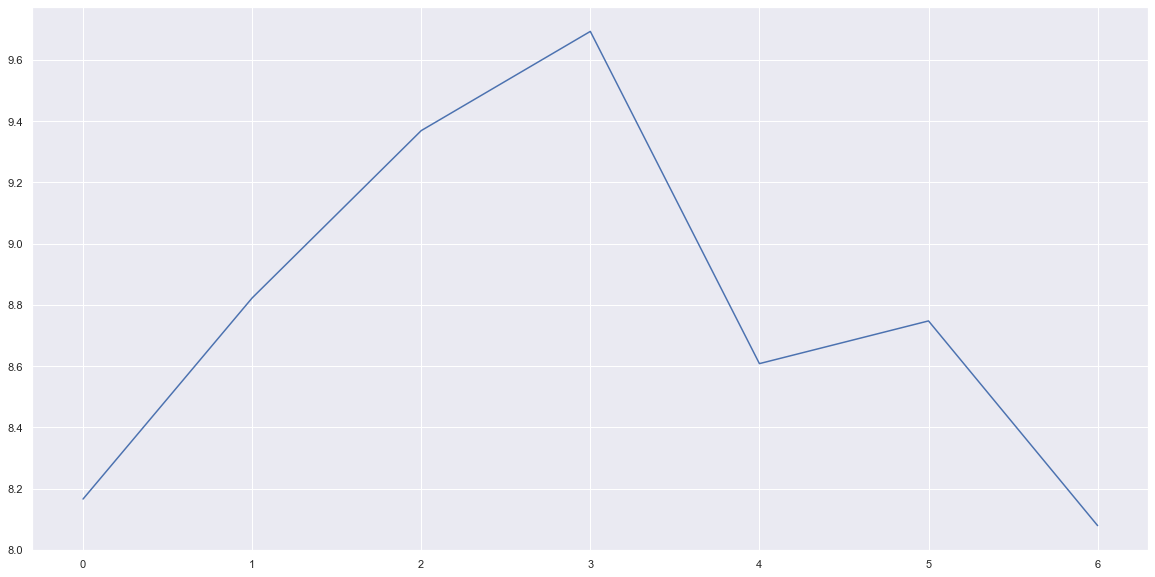

In [349]:
plt.figure(figsize=(20,10))
plt.plot(data.groupby(['WeekDay']).mean().index,data.groupby(['WeekDay']).mean()['DiscountPerc'])

This WeekDay plot tells us that the highest discount percetange are being given on the weekend (Highest on Thursday, then decreases until Sunday, and then increases again until Thursday). Remember Day 0 is Monday.
We are also seeing what we can infer to as two major days to make a reservation (Remember we are working on 5-day reservations) - Thursday for the weekend until Monday (first business day of the week in the US), and Sunday for the week itself until Thursday. These two dates has bigger percentage average than other dates near them.

In [11]:
data['ThuOrSat'] = (data['WeekDay'] ==  3) | (data['WeekDay'] ==  5)
data['ThuOrSat'] = data['ThuOrSat'].astype(int)

#### DiscountCode
The big question here is if there are any differences in total between the different discount codes, and if so, what can we do with them in order to improve our model. 

In [353]:
data.groupby(['Discount Code']).describe()

Original Price                                                   \
                       count         mean          std    min     25%     50%   
Discount Code                                                                   
1                    39271.0  1832.923149  1051.105658  312.0  1180.0  1611.0   
2                    60301.0  1786.242268  1033.424642  289.0  1111.0  1585.0   
3                    55720.0  1831.902728  1036.128954  316.0  1155.0  1602.5   
4                    32556.0  1879.698673  1055.969131  312.0  1203.0  1620.0   

                               Discount Price               ... isOctober2-4  \
                  75%      max          count         mean  ...          75%   
Discount Code                                               ...                
1              2171.0  29975.0        39271.0  1674.928191  ...          0.0   
2              2134.0  17200.0        60301.0  1632.794514  ...          0.0   
3              2180.0  17200.0        55720.0  1679.352728  ...          0.0   
4              2201.0  12075.0        32556.0  1735.264959  ...          0.0   

                   ThuOrSat                                               
               max    count      mean       std  min  25%  50%  75%  max  
Discount Code                                                             
1              1.0  39271.0  0.292710  0.455012  0.0  0.0  0.0  1.0  1.0  
2              1.0  60301.0  0.312333  0.463449  0.0  0.0  0.0  1.0  1.0  
3              1.0  55720.0  0.278392  0.448211  0.0  0.0  0.0  1.0  1.0  
4              1.0  32556.0  0.291037  0.454248  0.0  0.0  0.0  1.0  1.0  

[4 rows x 136 columns]

Average discounts for each discount code

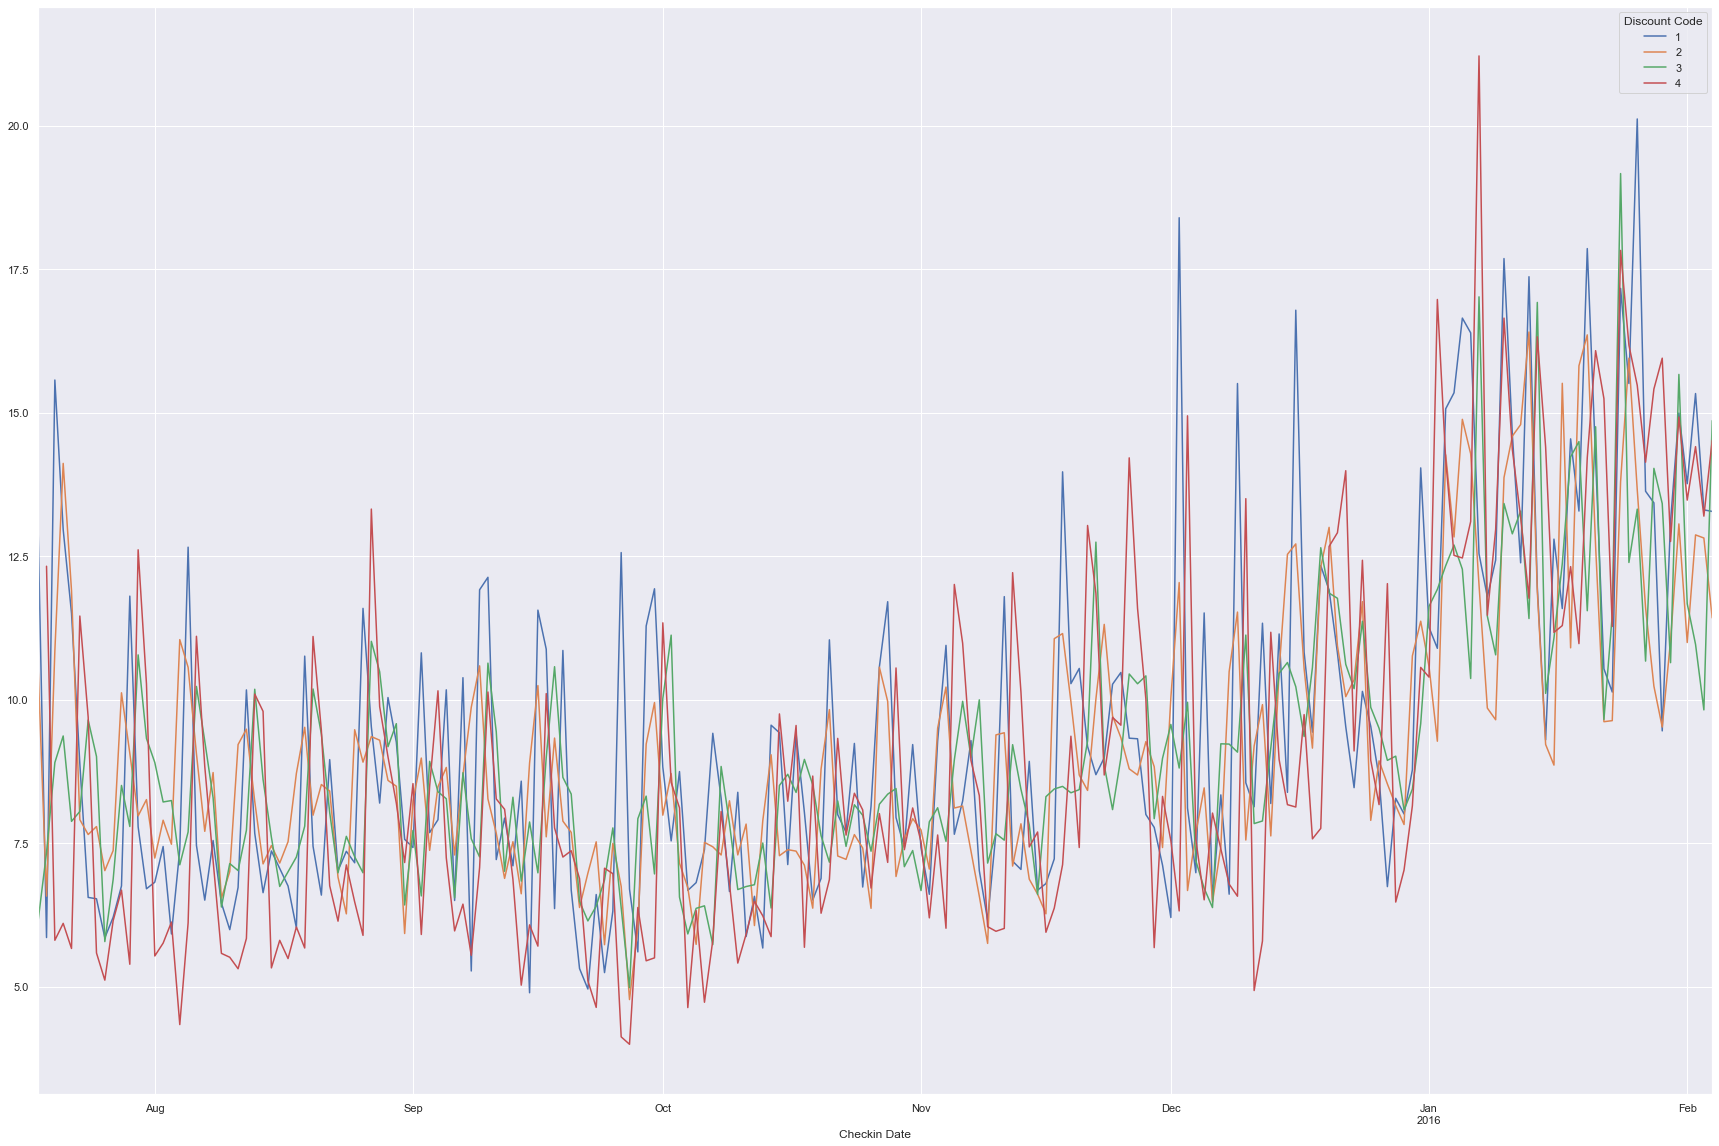

In [354]:
data.groupby(['Checkin Date','Discount Code']).mean()['DiscountPerc'].unstack().plot(figsize=(30,20))

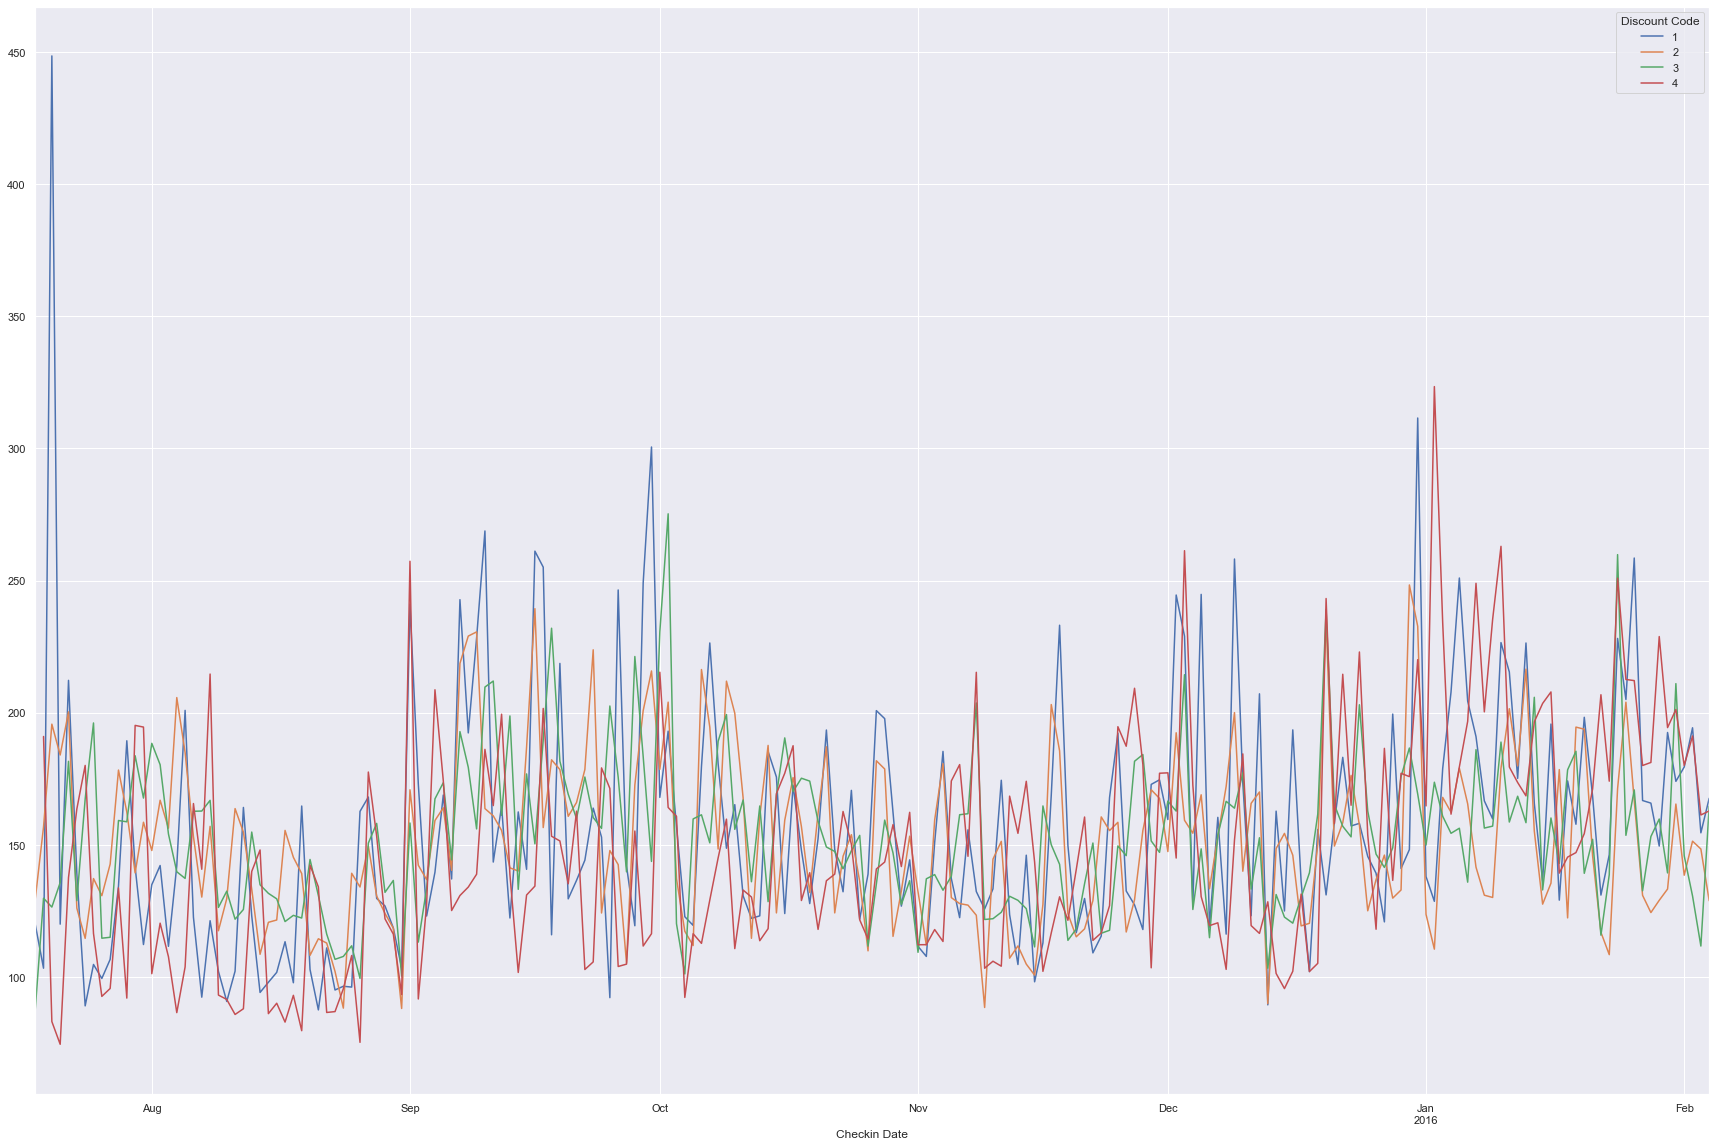

In [355]:
data.groupby(['Checkin Date','Discount Code']).mean()['DiscountDiff'].unstack().plot(figsize=(30,20))

In [356]:
data.groupby(['Checkin Date','Discount Code']).mean()['DiscountPerc'].unstack().idxmax(axis=1).value_counts()

1    69
4    48
3    43
2    42
dtype: int64

In [357]:
data.groupby(['Checkin Date','Discount Code']).mean()['DiscountPerc'].unstack().idxmin(axis=1).value_counts()

4    79
2    50
1    46
3    27
dtype: int64

We can see that although there are differences, this is no big "winner". Discount Code 1 might be a bit better than the others but not by a siginificant margin.

### Hotel Name
We want to see if the hotels can tell us more about the data, and if there are special policies to different groups of hotels.
This section is a bit problematic to infer anything from in our opinion, since we saw in the beginning that we don't have that many hotels which have large amount of data to learn from. 

In [203]:
data.groupby(['Hotel Name']).mean()

Snapshot Date  Checkin Date  Original Price  Discount Price  \
Hotel Name                                                                
0              249.909836    266.352459     2201.155738     2112.196721   
1              331.500000    346.500000      803.500000      701.750000   
2              300.087591    316.824818     1518.226277     1398.970803   
3              270.023256    275.348837     1833.279070     1659.162791   
4              311.625000    223.375000     2277.750000     2125.250000   
5              270.933333    291.066667     1970.800000     1849.466667   
6              278.722222    207.888889      338.777778      316.222222   
7              269.625000    274.375000     1078.750000      936.250000   
8              263.090476    279.980952     1234.519048     1121.814286   
9              312.234375    327.750000     1447.109375     1328.500000   
10             261.404762    277.476190     1427.595238     1327.761905   
11             258.000000    260.000000     1271.000000     1206.000000   
12             293.357143    309.732143     1286.160714     1215.160714   
13             269.978495    287.075269     1069.956989     1010.956989   
14             259.000000    267.000000      732.000000      570.000000   
15             269.000000    279.500000      817.000000      750.000000   
16             274.208520    260.477578     2403.339312     2241.917788   
17             283.361335    285.033372     1812.208285     1652.806674   
18             275.600000    262.475000     1592.075000     1509.875000   
19             276.600000    303.600000     1210.533333     1068.066667   
20             346.532258    357.919355     1555.967742     1333.516129   
21             317.950980    274.289216     3898.063725     3662.941176   
22             225.000000    236.500000      570.500000      514.250000   
23             272.147059    297.411765      649.411765      596.470588   
24             278.746528    288.479167     1967.326389     1871.045139   
25             269.123515    273.135392      835.370546      752.002375   
26             263.085837    279.536481     1478.025751     1412.150215   
27             265.909091    272.079545     1063.693182      986.011364   
28             315.149254    252.552239      753.626866      681.626866   
29             298.727273    237.886364      737.045455      684.159091   
...                   ...           ...             ...             ...   
524            294.000000    307.250000      545.250000      508.750000   
525            287.218233    236.239551     2151.408135     1971.638429   
526            259.726374    276.492308     1756.349451     1646.972527   
527            272.545699    253.627240     1955.385305     1846.045699   
528            263.119506    274.962469     2284.846914     2166.918519   
529            286.004678    259.548538     1793.987135     1689.916959   
530            265.709861    277.064385     2093.575387     1860.443358   
531            264.514563    282.796117     2125.398058     1947.990291   
532            312.500000    337.200000     1423.800000     1220.900000   
533            285.888889    301.777778     1699.666667     1420.444444   
534            272.074074    283.962963     4749.833333     4613.074074   
535            265.673913    286.739130     2015.000000     1736.217391   
536            297.285714    306.476190      546.619048      508.904762   
537            249.352941    260.000000     2084.176471     2002.000000   
538            271.553006    283.177479     1973.060918     1828.706751   
539            282.138211    298.146341      814.235772      642.170732   
540            239.000000    247.000000     1016.000000      956.750000   
541            287.375000    290.312500     1427.500000     1337.687500   
542            266.896552    273.000000     1222.750000     1142.189655   
543            308.291803    320.485246     1436.170492     1323.849180   
544            296.727588    270.9730

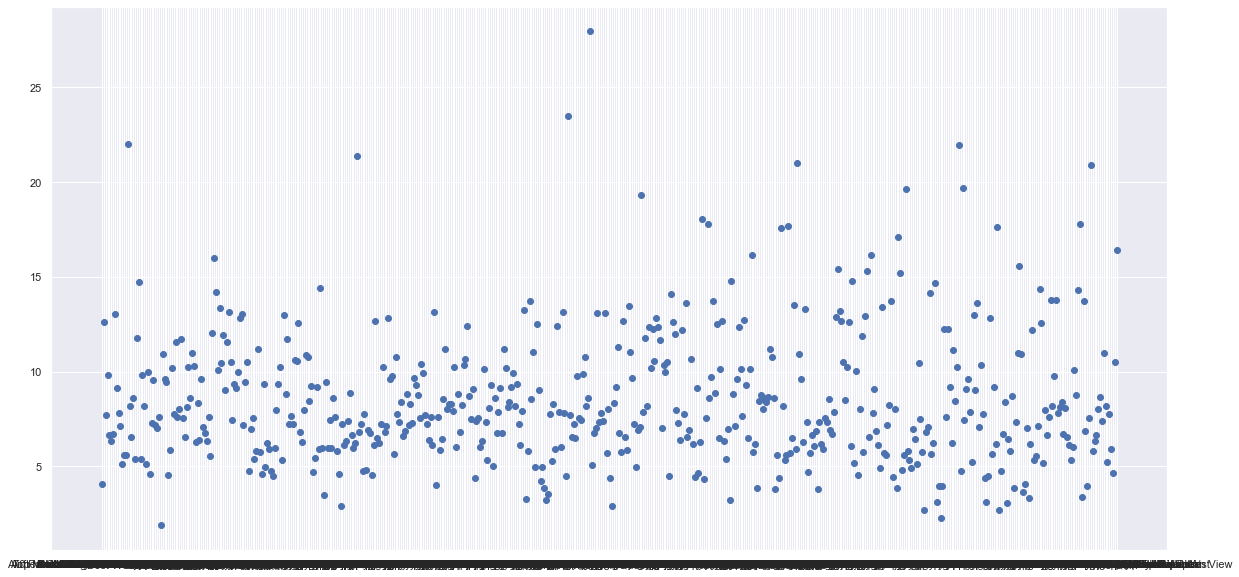

In [361]:
plt.figure(figsize=(20,10))
plt.scatter(data.groupby(['Hotel Name']).mean().index,data.groupby(['Hotel Name']).mean()['DiscountPerc'])

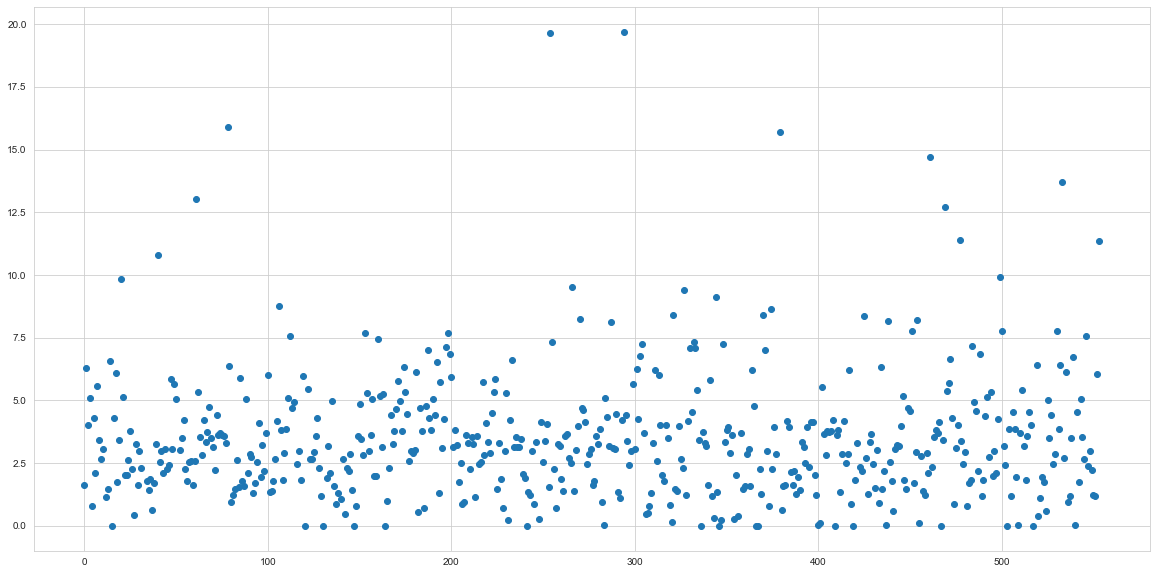

In [205]:
plt.figure(figsize=(20,10))
plt.scatter(data.groupby(['Hotel Name']).std().index,data.groupby(['Hotel Name']).std()['DiscountPerc'])

In [255]:
hotel_std = df.groupby(['Hotel Name']).std()['DiscountPerc']
hotel_std['size'] = df.groupby(['Hotel Name']).size()

In [358]:
hotel_std = pd.DataFrame({'std in perc': df.groupby(['Hotel Name']).std()['DiscountPerc'],
                         '# rows': df.groupby(['Hotel Name']).size()})

In [359]:
hotel_std.sort_values(by=['# rows'],ascending=False)

std in perc  # rows
Hotel Name                                                             
Newark Liberty International Airport Marriott          9.386335    5346
Hilton Garden Inn Times Square                         5.756700    4892
Residence Inn Newark Elizabeth Liberty Internat...     8.643486    4314
Westin New York at Times Square                        3.505849    3792
Loews Regency New York Hotel                           4.448261    3617
Viceroy New York                                       5.005640    3565
Four Seasons Hotel New York                            5.318222    3243
Langham Place New York Fifth Avenue                    4.331866    3203
The Carlyle A Rosewood Hotel                           6.338157    3078
DoubleTree by Hilton Metropolitan - New York City      7.589490    2866
Magnuson Convention Center Hotel                       1.112592    2862
Hilton Garden Inn New York West 35th Street            4.426849    2822
Hilton Garden Inn New York-Times Square Central        6.538378    2772
Conrad New York                                        6.367035    2677
Wyndham Garden Brooklyn Sunset Park                    3.526466    2599
Hilton Newark Airport                                  6.837864    2524
Omni Berkshire Place                                   5.405286    2358
Hilton Times Square                                    5.952047    2273
Park Hyatt New York                                    5.819985    2226
Homewood Suites by Hilton NY Midtown Manhattan ...     5.843730    2211
Grand Hyatt New York                                   5.269533    2165
The Plaza Hotel                                        4.935471    2149
Quality Inn Woodside                                   3.924858    2140
Hyatt Union Square New York                            4.161251    2114
Le Parker Meridien New York                            3.176911    2109
The New York EDITION                                   6.668742    2073
W New York - Union Square                              2.452457    2025
Renaissance Newark Airport Hotel                       8.400452    1951
Hampton Inn New York - 35th Street - Empire Sta...     4.477638    1930
The Lexington New York City Autograph Collection       2.961038    1920
...                                                         ...     ...
Orchard Street Hotel                                   3.755405       2
Radisson Hotel JFK Airport                             0.271914       2
The Brooklyn A Hotel                                   3.034496       2
AnYi Guesthouse Flushing                               6.575895       2
Anchor Inn                                             0.000000       2
Chelsea Savoy Hotel                                    3.026219       2
Hotel Luxe                                             0.291264       2
La Quinta Inn and Suites JFK Airport                   0.025984       2
The Court - A St Giles Premier Hotel                   0.020907       2
Fairfield Inn & Suites Newark Liberty Internati...     2.095131       2
Executive Hotel Le Soleil New York                     0.000000       2
Pointe Plaza Hotel                                     0.219872       2
The Nolitan                                            0.870844       2
Flatiron Hotel                                         0.796740       2
The Manhattan Club                                     2.111436       2
Red Roof Inn Queens                                    0.000000       2
Fitzpatrick Manhattan Hotel                            0.000000       2
Riviera Hotel                                               NaN       1
Ramada Flushing Queens                                      NaN       1
Super Family Flat in Little Italy                           NaN       1
Extended Stay America New York City - LaGuardia...          NaN       1
Americana Inn                                               NaN       1
Chelsea Pines Inn                                           NaN       1
Econo Lodge Times Sq

We might do some clustering where the classifier will be the average discount percentage. Right now it looks like most of the hotels have the same range of deviation. we can consider hotels with std of over ~7.5 to be 'suspicious'.

We might also add a feature that measures the range of the average percentage for any hotel.

The average discount price of any hotel, divided by the Hotel Stars:

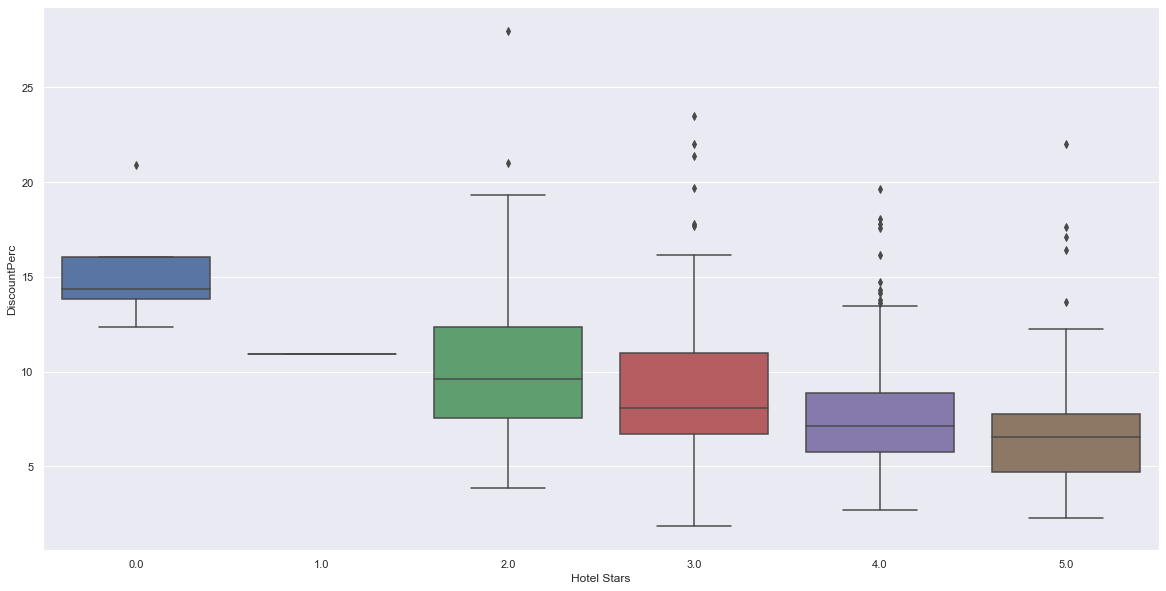

In [363]:
plt.figure(figsize=(20,10))
sns.boxplot(data.groupby(['Hotel Name']).mean()['Hotel Stars'],data.groupby(['Hotel Name']).mean()['DiscountPerc'])

In [374]:
data.groupby(['Hotel Name']).mean()['Hotel Stars'].value_counts()

4.0    216
3.0    186
2.0     78
5.0     69
0.0      4
1.0      1
Name: Hotel Stars, dtype: int64

The percieved outliers:

In [365]:
d4_list = pd.Index([],dtype='object', name='Hotel Name')
for i in range(0,6):
    d4 = data.groupby(['Hotel Name']).mean().loc[data.groupby(['Hotel Name']).mean()['Hotel Stars'] == i]['DiscountPerc']
    Q1 = d4.quantile(0.25)
    Q3 = d4.quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 

    filter = (d4 <= Q1 - 1.5 * IQR) | (d4 >= Q3 + 1.5 *IQR)
    #print(d4.loc[filter].keys())
    d4_list.union(d4.loc[filter].keys())

In [372]:
listi = ['Williamsburg Hostel','Howard Johnson Long Island City', 'Riviera Motor Inn Brooklyn',
        'AnYi Guesthouse Flushing',
       'Fairfield Inn New York Midtown Manhattan Penn Station',
       'Hotel Pennsylvania',
       'Residence Inn Newark Elizabeth Liberty International Airport',
       'The Milburn Hotel', 'Wellington Hotel','Avalon Hotel', 'Newark Liberty International Airport Marriott',
       'NobleDEN Hotel', 'Radisson Hotel JFK Airport',
       'Renaissance Newark Airport Hotel', 'The Duchamp - Corporate Apartment',
       'The Langston - Corporate Apartment', 'The Paper Factory Hotel',
       'Two Bedroom Self Catering Apartment- Midtown West',
       'Washington Jefferson Hotel','Hotel Americano', 'The Carlyle A Rosewood Hotel',
       'The Marmara Park Avenue', 'The Ritz-Carlton New York Battery Park',
       'the Quin']
len(listi)
data.loc[data['Hotel Name'].isin(listi)].shape

(15177, 21)

Working with dates and categorical features is hard for the model, so we tweak it. then, we treat the dates as a cyclical features.
We have tried many different features and approaches, we wrote what gave the best results (in terms of MAE and R^2).

As we said earlier, the task's performace is evaluated by the r-squared between the predictions and the hotels with the most data. However, the R^2 measure only represents the variance of the prediction explained by the model, and because we saw such a strong correlation between the Original Price and the Discount Price, we can guess it will be high nonetheless. Therefore, we added the MAE, mean squared error and the MSE mean squared-root error, to give some perspective.

In [23]:
X = data.copy()
X['Hotel Name'] = X['Hotel Name'].astype('category')
X['Hotel Name'] = X['Hotel Name'].cat.codes

#data['Snapshot Date'] = data['Snapshot Date'].dt.dayofyear
#data['Checkin Date'] = data['Checkin Date'].dt.dayofyear 
days = 365
X['sin_snapshot'] = np.sin(2*np.pi*X['Snapshot Date'].dt.dayofyear  /days)
X['cos_snapshot'] = np.cos(2*np.pi*X['Snapshot Date'].dt.dayofyear  /days)
X['sin_checkin'] = np.sin(2*np.pi*X['Checkin Date'].dt.dayofyear /days)
X['cos_checkin'] = np.cos(2*np.pi*X['Checkin Date'].dt.dayofyear /days)

In [24]:
y = X['Discount Price']
#X = data.drop(columns=['Snapshot Date','Checkin Date','Discount Price','DiscountPerc','DiscountDiff'])
#X = X.drop(columns=['Snapshot Date','Checkin Date','Discount Price','DiscountPerc','Discount Code','DiscountDiff','Snap_day','Checkin_day','Snap_month','Checkin_month','Available Rooms','Snap_week','Checkin_week'])

In [25]:
X = pd.get_dummies(X,columns=['Hotel Stars'])

#### Modeling

As we saw in the pairplot, there's a very strong LINEAR correlation between the original price and the discount price, hence we decided to go with the linear/polynomial regression models, to see what we can achieve with this data.

The task's estimator is the R^2 of the prices the model predicts to the 40 hotels with the most samples in the data:

In [26]:
rows_to_drop = ['Snapshot Date','Checkin Date','Discount Price',
                'DiscountPerc','DiscountDiff',
                'Snap_day','Checkin_day','Snap_month','Checkin_month',
                'Available Rooms','Snap_week','Checkin_week']

In [27]:
X_data = X.drop(columns = rows_to_drop)

In [30]:
forty_hotels = X.loc[X['Hotel Name'].isin(X['Hotel Name'].value_counts()[0:40].keys())]
fh_data = forty_hotels.drop(columns=rows_to_drop)
y_fh = forty_hotels['Discount Price']

Linear Regression:

In [446]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.5, random_state=0)
lr = LinearRegression(fit_intercept=True,normalize = True)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [445]:
y_pred = lr.predict(X_test)
print('avg error (mae)',np.sum(np.abs(y_test.get_values()-y_pred))/len(y_pred))
print('rmse of train set',mean_squared_error(y_train,lr.predict(X_train)))
print('rmse of test set',mean_squared_error(y_test,y_pred))
print('mae ',mean_absolute_error(y_test,y_pred))
print ('r2 score: ',r2_score(y_test,y_pred),'\n')

fh_pred = lr.predict(fh_data)
print('rmse of fortyhotels set',mean_squared_error(y_fh,fh_pred))
print('mae ',mean_absolute_error(y_fh,fh_pred))
print ('r2 score: ',r2_score(y_fh,fh_pred))

avg error (mae) 79.22406613325667
rmse of train set 15644.14242537205
rmse of test set 15621.775117142999
mae  79.22406613325667
r2 score:  0.9837818283471229 

rmse of fortyhotels set 20780.253140028144
mae  91.37504169169193
r2 score:  0.9825783998946058


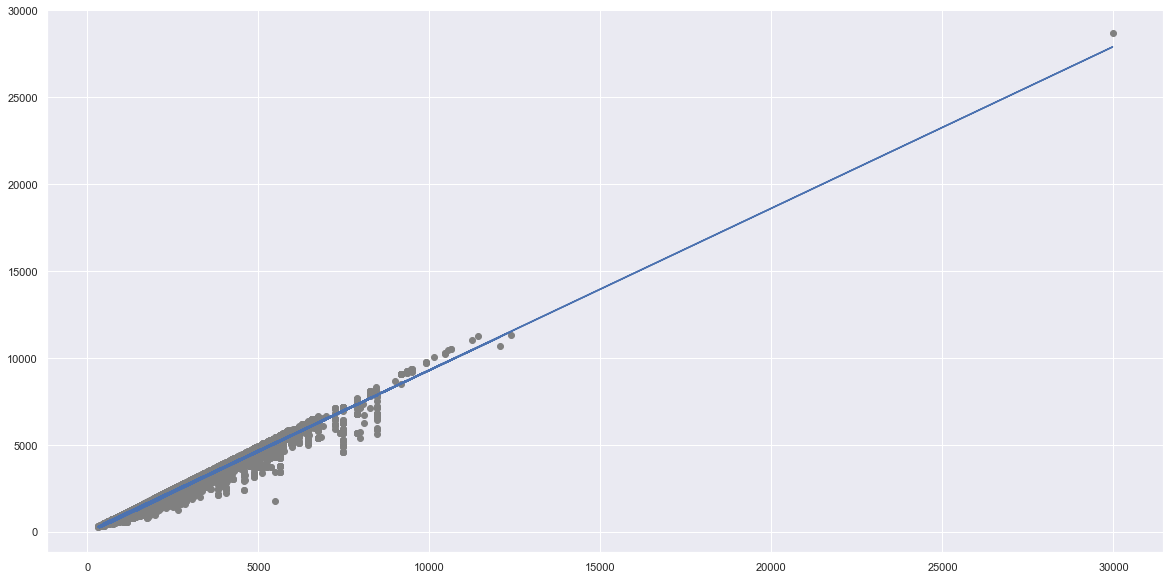

In [462]:
plt.figure(figsize=(20,10))
plt.scatter(X_test['Original Price'],y_test, color = 'grey')
plt.plot(X_test['Original Price'],y_pred)

Polynomial Regression:

In [267]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(3),Ridge())
poly_model.fit(X_train,y_train)

y_pred = poly_model.predict(X_test)
print('avg error (mae)',mean_absolute_error(y_test,y_pred))
print('rmse ',mean_squared_error(y_train,lr.predict(X_train)))
print('rmse ',mean_squared_error(y_test,y_pred))
print (r2_score(y_test,y_pred),'\n')

fh_pred = poly_model.predict(fh_data)
print('rmse of fortyhotels set',mean_squared_error(y_fh,fh_pred))
print('mae ',mean_absolute_error(y_fh,fh_pred))
print ('r2 score: ',r2_score(y_fh,fh_pred))

avg error (mae) 74.21747501322153
rmse  15543.500794787245
rmse  40943.19533165422
0.9574355690015147 

rmse of fortyhotels set 42145.225105382226
mae  83.51888143065148
r2 score:  0.96466658739958


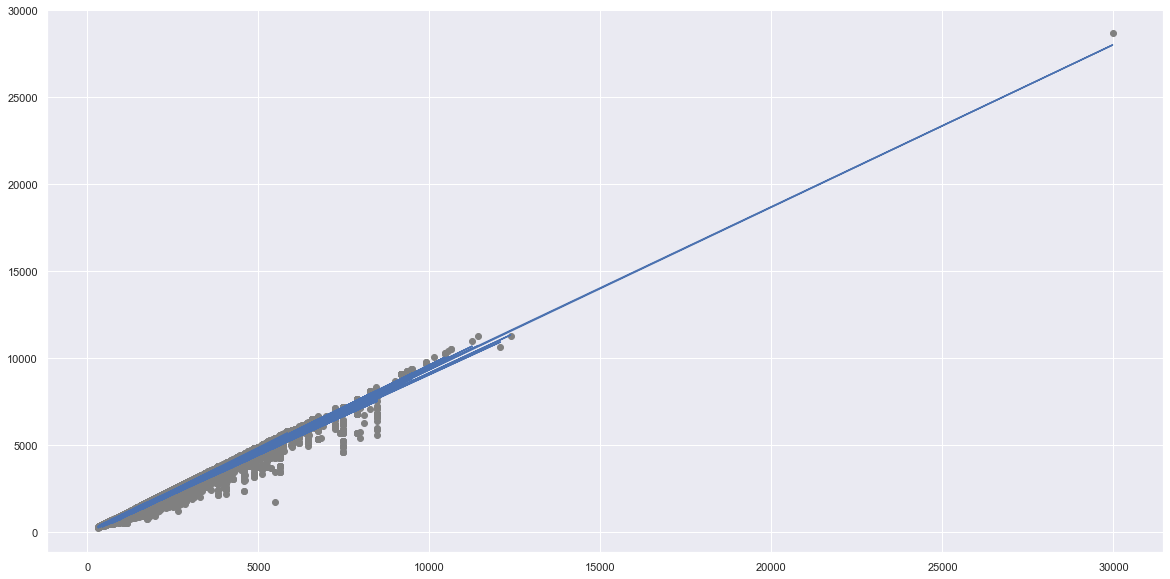

In [467]:
plt.figure(figsize=(20,10))
plt.scatter(X_test['Original Price'],y_test, color = 'grey')
plt.plot(X_test['Original Price'],y_pred)

Separating the data according to the observation about the Snapshot Date we saw earlier

In [488]:
data1 = X[(X['Snapshot Date'] <= datetime(2015,10,14))]
data2 = X[(X['Snapshot Date'] > datetime(2015,10,14))]
curr_data = [data1,data2]
print(data1.shape + data2.shape)

(105634, 30, 82214, 30)


In [552]:
lrc = [LinearRegression(fit_intercept=True,normalize = True),LinearRegression(fit_intercept=True,normalize = True)]
for i,chunk in enumerate(curr_data):
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(chunk.drop(columns=rows_to_drop), chunk['Discount Price'], test_size=0.5, random_state=0)
    lrc[i].fit(Xc_train, yc_train)
    yc_pred = lrc[i].predict(Xc_test)
    print('data chunk num:',i+1)
    print('avg error ',np.sum(np.abs(yc_test.get_values()-yc_pred))/len(yc_pred))
    print('rmse of train',mean_squared_error(yc_train,lrc[i].predict(Xc_train)))
    print('rmse of test',mean_squared_error(yc_test,yc_pred))
    print('mae ',mean_absolute_error(yc_test,yc_pred))
    print ('r2 score: ',r2_score(yc_test,yc_pred),'\n')

data chunk num: 1
avg error  75.04924958512503
rmse of train 14391.33581756091
rmse of test 14357.987796448728
mae  75.04924958512503
r2 score:  0.9857495309727388 

data chunk num: 2
avg error  83.71645661472442
rmse of train 16778.79327542899
rmse of test 17292.850676889815
mae  83.71645661472442
r2 score:  0.9793605704671124 



The measurements above were not calculated against the forty hotels inputs, but we still can infer that the data seem much more noisy in the second chunk.

Simple regression with one feature - Original Price. Correlation was very high so we wanted to see what we will get by using only this feature.

In [539]:
from sklearn.metrics import mean_squared_error
x1, x2, y1, y2 = train_test_split(X['Original Price'], y, test_size=0.4)
lr1 = LinearRegression(fit_intercept=True,normalize = True)
lr1.fit(x1.to_numpy().reshape(-1, 1), y1)
y2_pred = lr1.predict(x2.to_numpy().reshape(-1, 1))
print('avg error ',np.sum(np.abs(y2.get_values()-y2_pred))/len(y2_pred))
print('min-sq error ',mean_squared_error(y2,y2_pred))
print('r2 score ',r2_score(y2,y2_pred))
print('Cofficients ',lr1.coef_,'\n')

fh_pred = lr1.predict(fh_data['Original Price'].to_numpy().reshape(-1, 1))
print('rmse of fortyhotels set',mean_squared_error(y_fh,fh_pred))
print('mae ',mean_absolute_error(y_fh,fh_pred))
print ('r2 score: ',r2_score(y_fh,fh_pred))

avg error  79.64353035996405
min-sq error  15713.296254600804
r2 score  0.9837363972370547
Cofficients  [0.93512836] 

rmse of fortyhotels set 21615.974260287392
mae  93.6139447681104
r2 score:  0.9818777539949299


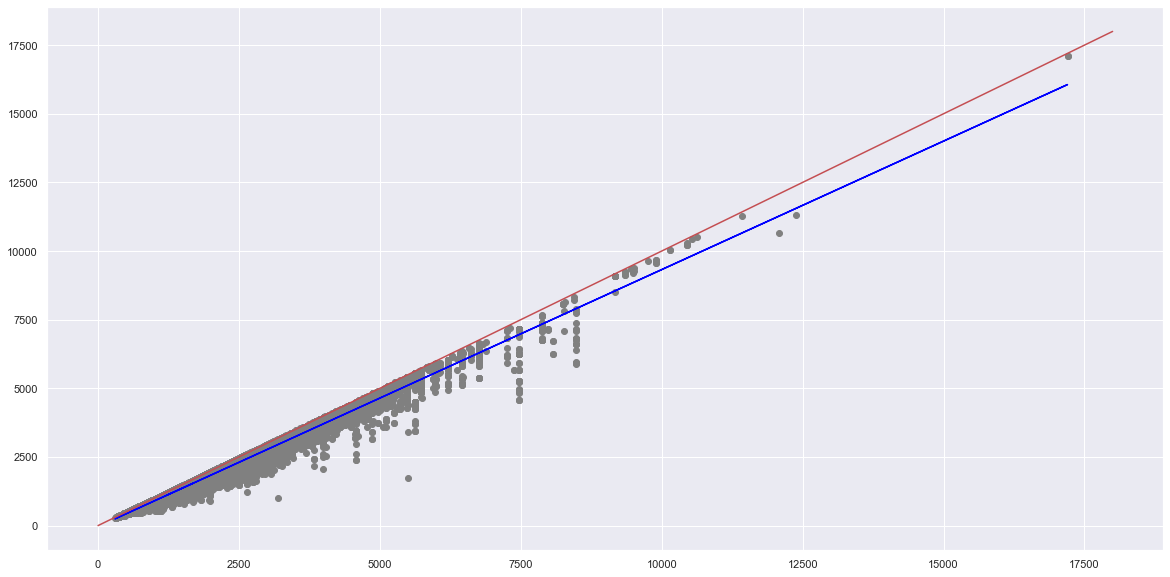

In [505]:
plt.figure(figsize=(20,10))
plt.plot(x2,y2_pred,c='blue')
x = np.linspace(0,18000,200)
plt.plot(x,x,'-r')
plt.scatter(x2,y2,c='grey')

Lasso linear model (a shrinkage and selection method for linear regression to avoid overfitting, although it doesn't seem like our data is overfitting)

In [49]:
from sklearn import linear_model
llr = linear_model.Lasso(alpha=0.05)

llr.fit(X_train,y_train)

y_pred_llr = llr.predict(X_test)
print('avg error (mae)',mean_absolute_error(y_test,y_pred_llr))
print('rmse ',mean_squared_error(y_train,lr.predict(X_train)))
print('rmse ',mean_squared_error(y_test,y_pred_llr))
print (r2_score(y_test,y_pred_llr),'\n')

fh_pred = llr.predict(fh_data)
print('rmse of fortyhotels set',mean_squared_error(y_fh,fh_pred))
print('mae ',mean_absolute_error(y_fh,fh_pred))
print ('r2 score: ',r2_score(y_fh,fh_pred))

avg error (mae) 79.02370655100117
rmse  15543.500794787245
rmse  15747.998083997629
0.9836284253737185 

rmse of fortyhotels set 20809.05199420196
mae  91.32123847108508
r2 score:  0.9825542557170769


#### Inferring the next best query - Active Learning
Until now, we used a lot of data in our models, but the primary goal of this task was to use the least amount of data with a minimal penalty to our prediction - in other words, to determine how many samples are needed for a good model, or which ones. 

In order to understand what are the best ones to sample, we will use the active learning method.

*We wanted to use modAL library, but for some reason it stopped working for some bug in the teach function. therefore we did it manually below (skip the modAL cells) 

In [269]:
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from modAL.disagreement import max_std_sampling
from modAL.utils import multi_argmax
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
import math

data_centroid = X_data.sum(axis=0)/len(X_data)

def greedy_sampling(regressor, X_pool,n_instances = 1):
    n_samples = len(X_pool)
    #change the line below to change the utility function
    utility = shortest_distance_to_line(regressor,X_pool)
    query_index = multi_argmax(utility,n_instances = n_instances)
    return query_index,X_pool.iloc[query_index]

def shortest_distance_to_dp(regressor,X_pool):
    for i in range(len(X_pool)):
        print ('lateron')
        
def shortest_distance_to_line(regressor,X_pool):
        return safe_sparse_dot(X_pool, regressor.estimator.coef_.T,dense_output=True) + regressor.estimator.intercept_
    
def random_sampling(regressor,X_pool):
    query_index = np.random.choice(range(len(X_pool)))
    return query_index, X_pool.iloc[query_index]

def closest_to_pool_centroid(regressor,X_pool):
    centroid = X_pool.sum(axis=0)/len(X_pool)
    closest, _ = pairwise_distances_argmin_min(centroid.to_numpy().reshape(1,-1), X_pool)
    return closest[0],X_pool.iloc[closest[0]]

def closest_to_data_centroid(regressor,X_pool):
    centroid = data_centroid
    closest, _ = pairwise_distances_argmin_min(centroid.to_numpy().reshape(1,-1), X_pool)
    return closest[0],X_pool.iloc[closest[0]]
    
al_regressor = ActiveLearner(
    estimator = LinearRegression(fit_intercept=True,normalize = True),
    query_strategy=random_sampling)

initial_rows = 2#math.floor(len(data)*0.0001) # only 18 rows    
initial_indices = np.random.choice(range(len(data)), size=initial_rows, replace=False)
X_training, y_training = X_data.iloc[initial_indices], y.iloc[initial_indices]
unusedX = X_data.drop(X_data.index[initial_indices])
unusedy = y.drop(y.index[initial_indices])
#X_training.drop(columns=rows_to_drop,inplace = True)
al_regressor.fit(X_training,y_training)
print('AL regressor first train on data')

AL regressor first train on data


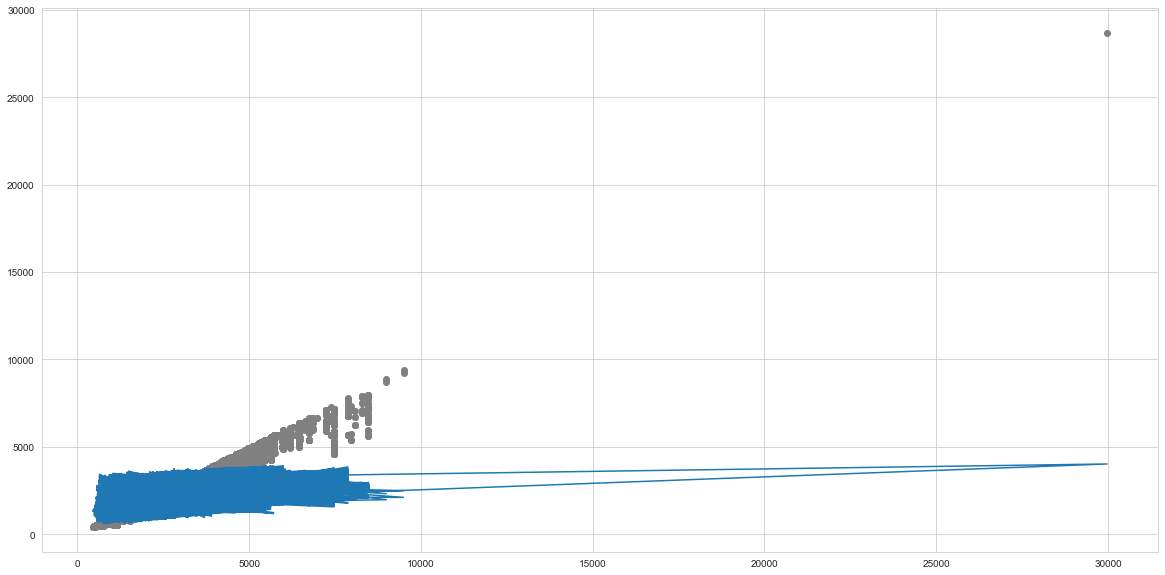

rmse of fortyhotels set 1336908.1024572866
mae  926.1821772639009
r2 score:  -0.12082745969092934


In [270]:
al_fh_pred = al_regressor.predict(fh_data)
plt.figure(figsize=(20,10))
plt.scatter(fh_data['Original Price'],y_fh, color = 'grey')
plt.plot(fh_data['Original Price'],al_fh_pred)
plt.show()
print('rmse of fortyhotels set',mean_squared_error(y_fh,al_fh_pred))
print('mae ',mean_absolute_error(y_fh,al_fh_pred))
print('r2 score: ',r2_score(y_fh,al_fh_pred))

In [ ]:
n_queries = 10#math.floor(len(X)*0.5)
mse = []
mae = []
r2 = []
for i in range(n_queries):
    query_index, query_instance = al_regressor.query(unusedX)
    al_regressor.teach(unusedX.iloc[query_index], unusedy[query_index])
    unusedX.drop(unusedX.index[query_index],inplace=True)
    unusedy.drop(unusedy.index[query_index],inplace=True)
    al_fh_pred = al_regressor.predict(fh_data)
    
    mse.append(mean_squared_error(y_fh,al_fh_pred))
    mae.append(mean_absolute_error(y_fh,al_fh_pred))
    r2.append(r2_score(y_fh,al_fh_pred))
    
    #print('rmse of fortyhotels set',mean_squared_error(y_fh,al_fh_pred))
    #print('mae ',mean_absolute_error(y_fh,al_fh_pred))
    #print('r2 score: ',r2_score(y_fh,al_fh_pred))

### Linear regression, random sampling:

The most trivial way to understand how many rows are needed to give a good prediction is to incrementally sample the inputs by random.

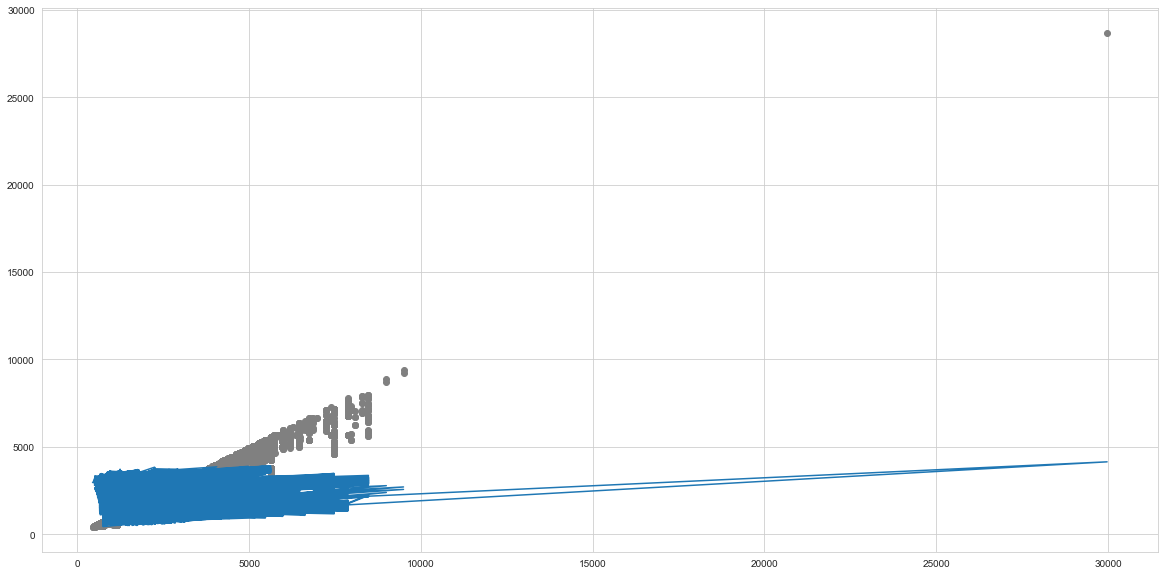

rmse of fortyhotels set 1642261.0449526545
mae  981.1427120915699
r2 score:  -0.3768270771793487


In [359]:
initial_indices = np.random.choice(range(len(X_data)), size=initial_rows, replace=False)
X_training, y_training = X_data.iloc[initial_indices], y.iloc[initial_indices]
unusedX = X_data.drop(X_data.index[initial_indices])
unusedy = y.drop(y.index[initial_indices])
lr_rand = LinearRegression(fit_intercept=True,normalize = True)
lr_rand.fit(X_training, y_training)

al_fh_pred = lr_rand.predict(fh_data)
plt.figure(figsize=(20,10))
plt.scatter(fh_data['Original Price'],y_fh, color = 'grey')
plt.plot(fh_data['Original Price'],al_fh_pred)
plt.show()

print('rmse of fortyhotels set',mean_squared_error(y_fh,al_fh_pred))
print('mae ',mean_absolute_error(y_fh,al_fh_pred))
print('r2 score: ',r2_score(y_fh,al_fh_pred))

In [367]:
n_queries = math.floor(len(X)*0.1)
mse = []
mae = []
r2 = []

In [368]:
for i in range(n_queries):
    query_index = np.random.choice(range(len(unusedX)))
    initial_indices = np.append(initial_indices,unusedX.iloc[query_index].name)
    unusedX.drop(unusedX.index[query_index],inplace=True)
    unusedy.drop(unusedy.index[query_index],inplace=True)
    lr_rand.fit(X_data.iloc[initial_indices], y.iloc[initial_indices])
    
    al_fh_pred = lr_rand.predict(fh_data)
    mse.append(mean_squared_error(y_fh,al_fh_pred))
    mae.append(mean_absolute_error(y_fh,al_fh_pred))
    r2.append(r2_score(y_fh,al_fh_pred))

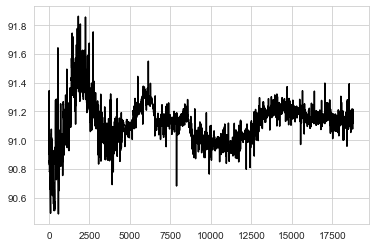

mae after 100 samples: 90.51650304121206
mae after 500 samples: 91.0103121752269
mae after 1000 samples: 91.12787808608955
mae after 1500 samples: 91.43054951340818


In [370]:
plt.plot(range(n_queries),mae,color='black')
plt.show()
print ('mae after 100 samples:',mae[98])
print ('mae after 500 samples:',mae[498])
print ('mae after 1000 samples:',mae[998])
print ('mae after 1500 samples:',mae[1498])

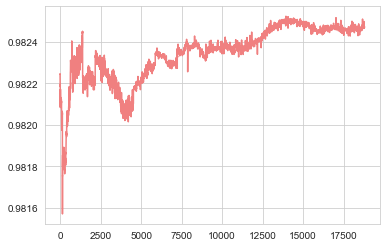

r2 after 100 samples: 0.9820035149535216
r2 after 500 samples: 0.9820174647123818
r2 after 1000 samples: 0.9822910750949724
r2 after 1500 samples: 0.9822215298216626


In [371]:
plt.plot(range(n_queries),r2,color='lightcoral')
plt.show()
print ('r2 after 100 samples:',r2[98])
print ('r2 after 500 samples:',r2[498])
print ('r2 after 1000 samples:',r2[998])
print ('r2 after 1500 samples:',r2[1498])

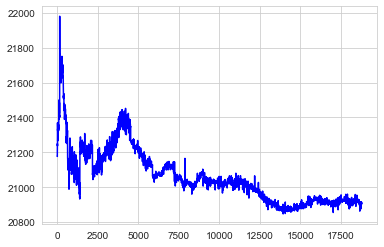

mse after 100 samples: 21465.96825975601
mse after 500 samples: 21449.329172725742
mse after 1000 samples: 21122.97034359557
mse after 1500 samples: 21205.923021611776


In [372]:
plt.plot(range(n_queries),mse,color='blue')
plt.show()
print ('mse after 100 samples:',mse[98])
print ('mse after 500 samples:',mse[498])
print ('mse after 1000 samples:',mse[998])
print ('mse after 1500 samples:',mse[1498])

We can see that at first, the r^2 is bad and the mae is very high (in regards to the average discount price). After very little iterations the mae is already at about ~91, which is about 0.05 error (in terms of the average discount price for the 40 hotels). The random sampling is still not so good when using only 10 percent of the data, as we can see that as the iterations go, there was some worsening in the model's mae and r^2.
We can't derive too much information from it because it was random, but we can see that the scores are getting better after 10-12k samples, which is less than 0.1 of the data.

Small test to see what happens when we train on 0.2,0.3..0.5 of the data.

In [374]:
mse_ = []
mae_ = []
r2_ = []

In [405]:
for i in range(0,4):
    querys = np.random.choice(range(len(unusedX)), size=n_queries, replace=False)
    initial_indices = np.append(initial_indices,unusedX.iloc[querys,:].index.values)
    unusedX.drop(unusedX.index[querys],inplace=True)
    unusedy.drop(unusedy.index[querys],inplace=True)
    lr_rand.fit(X_data.iloc[initial_indices], y.iloc[initial_indices])
    
    al_fh_pred = lr_rand.predict(fh_data)
    mse_.append(mean_squared_error(y_fh,al_fh_pred))
    mae_.append(mean_absolute_error(y_fh,al_fh_pred))
    r2_.append(r2_score(y_fh,al_fh_pred))

In [408]:
ranges = [0.2,0.3,0.4,0.5]

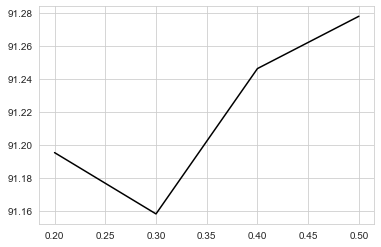

In [410]:
plt.plot(ranges,mae_,color='black')
plt.show()

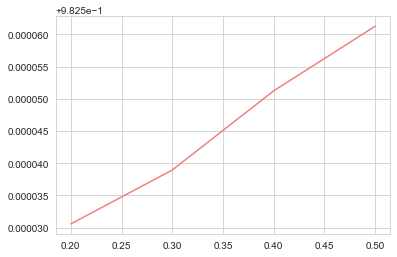

[0.9825305673453821, 0.9825389386825317, 0.9825512463527454, 0.9825612792579493]


In [412]:
plt.plot(ranges,r2_,color='lightcoral')
plt.show()
print(r2_)

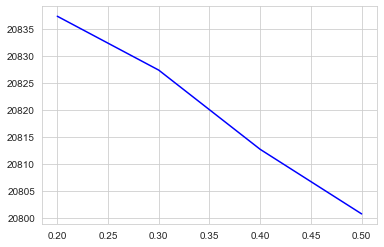

In [413]:
plt.plot(ranges,mse_,color='blue')
plt.show()

The model seems to get a bit better in terms of r^2 but the mae for this run hasn't changed much. somewhere around 0.3 train/test seems already reasonable.

### Linear regression, greedy sampling:
Since the modAL library (and other ones) didn't seem to have utility and query functions that are suited for regressions (and linear regression in particular), we wanted to see if there are other methods in the literature that cover such sampling methods for active learning.

The idea behind the "greedy sampling", is first to take the sample that is the most representative of the data (closest to the centroid), and incrementally select the sample that is the farthest away from the already selected samples, in order to achieve diversity in the model. (based on
https://arxiv.org/pdf/1808.04245.pdf )


In [548]:
from sklearn.metrics.pairwise import euclidean_distances
def query_greedysample(labeled_data,samples):
    #if len(labeled_data) == 1 :
    return np.argmax(euclidean_distances(samples,labeled_data.to_numpy().reshape(1,-1)).min(axis=1))

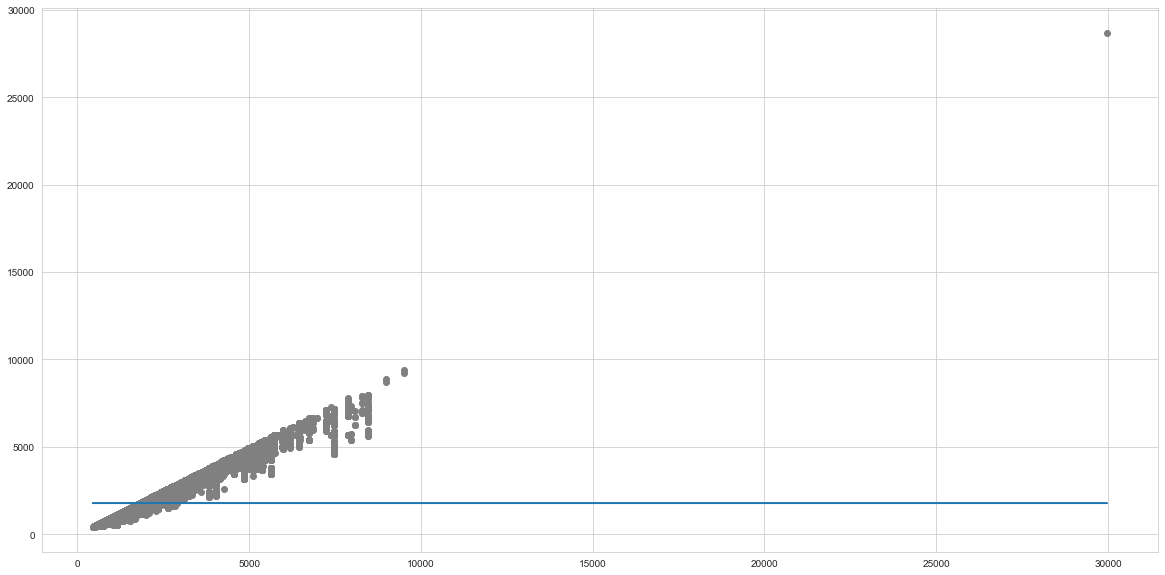

rmse of fortyhotels set 1197285.755887913
mae  772.8056299476192
r2 score:  -0.003771874693128563


In [549]:
data_centroid = X_data.sum(axis=0)/len(X_data)
closest_to_cent = np.argmin(euclidean_distances(X_data,data_centroid.to_numpy().reshape(1, -1)))
initial_indices = [closest_to_cent]

X_training, y_training = X_data.iloc[initial_indices], y.iloc[initial_indices]
unusedX = X_data.drop(X_data.index[initial_indices])
unusedy = y.drop(y.index[initial_indices])
lr_greedy = LinearRegression(fit_intercept=True,normalize = True)
lr_greedy.fit(X_training, y_training)

gl_fh_pred = lr_greedy.predict(fh_data)
plt.figure(figsize=(20,10))
plt.scatter(fh_data['Original Price'],y_fh, color = 'grey')
plt.plot(fh_data['Original Price'],gl_fh_pred)
plt.show()

print('rmse of fortyhotels set',mean_squared_error(y_fh,gl_fh_pred))
print('mae ',mean_absolute_error(y_fh,gl_fh_pred))
print('r2 score: ',r2_score(y_fh,gl_fh_pred))

In [550]:
n_queries_greedy = math.floor(len(X)*0.05)
mse_greedy = []
mae_greedy = []
r2_greedy = []

In [551]:
for i in range(n_queries_greedy):
    query_index = query_greedysample(X_training,unusedX)
    initial_indices = np.append(initial_indices,unusedX.iloc[query_index].name)
    unusedX.drop(unusedX.index[query_index],inplace=True)
    unusedy.drop(unusedy.index[query_index],inplace=True)
    lr_greedy.fit(X_data.iloc[initial_indices], y.iloc[initial_indices])
    
    gl_fh_pred = lr_greedy.predict(fh_data)
    mse_greedy.append(mean_squared_error(y_fh,gl_fh_pred))
    mae_greedy.append(mean_absolute_error(y_fh,gl_fh_pred))
    r2_greedy.append(r2_score(y_fh,gl_fh_pred))

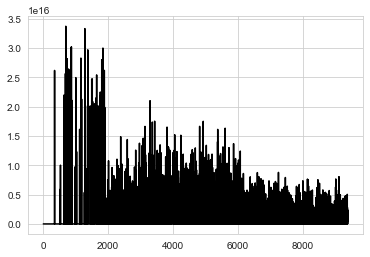

In [552]:
plt.plot(range(n_queries_greedy),mae_greedy,color='black')
plt.show()
#print ('mae after 100 samples:',mae_greedy[98])
#print ('mae after 500 samples:',mae_greedy[498])
#print ('mae after 1000 samples:',mae_greedy[998])
#print ('mae after 1500 samples:',mae_greedy[1498])

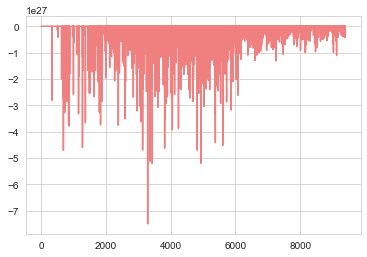

In [553]:
plt.plot(range(n_queries_greedy),r2_greedy,color='lightcoral')
plt.show()
#print ('r2 after 100 samples:',r2[98])
#print ('r2 after 500 samples:',r2[498])
#print ('r2 after 1000 samples:',r2[998])
#print ('r2 after 1500 samples:',r2[1498])

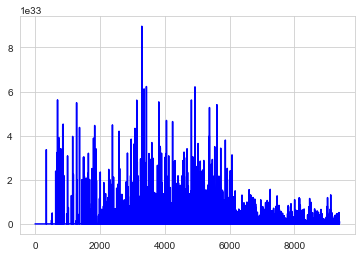

In [562]:
plt.plot(range(n_queries_greedy),mse_greedy,color='blue')
plt.show()
#print ('mse after 100 samples:',mse[98])
#print ('mse after 500 samples:',mse[498])
#print ('mse after 1000 samples:',mse[998])
#print ('mse after 1500 samples:',mse[1498])

End.

## Conclusions
As it seems, since overall the data has a strong correlation between the Original Price and the Discount Price, there's no need for too many samples to get a good prediction with an error rate of about 5%. 

Still, the data is pretty sparse (for this domain) and as we learned some parts of it are noisy, so there is a need for further investigation of the data to try to achieve a better overall result.

Something for the future - a SVR model, rmsle and some old observations (appendix 4)

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

discount price - original price (linear), available rooms (negative slope, like -log),hotel stars(linear bar maximum), daydiff (shallow negative slope). 

In [ ]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf', gamma=0.1, epsilon=.1)
#svr_lin = SVR(kernel='linear', C=100, gamma='auto')
#svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1)

svr_rbf.fit(X_train, y_train)
#svr_lin.fit(X_train, y_train)
#svr_poly.fit(X_train, y_train)

rbf_pred = svr_rbf.predict(X_test)
#lin_pred = svr_lin.predict(X_test)
#poly_pred = svr_poly.predict(X_test)

print('rbf avg error ',np.sum(np.abs(y_test.get_values()-rbf_pred))/len(rbf_pred))
print (r2_score(y_test,rbf_pred))

#print('lin avg error ',np.sum(np.abs(y_test.get_values()-lin_pred))/len(lin_pred))
#print (r2_score(y_test,lin_pred))

#print('poly error ',np.sum(np.abs(y_test.get_values()-poly_pred))/len(poly_pred))
#print (r2_score(y_test,poly_pred))

In [ ]:
print(r2_score(forty_hotels_values,svr_rbf.predict(forty_hotels)))
print(r2_score(forty_hotels_values,svr_lin.predict(forty_hotels)))
print(r2_score(forty_hotels_values,svr_poly.predict(forty_hotels)))

In [583]:
y_fh.to_numpy()

array([1345, 1525, 1183, ..., 1397, 1648, 1743], dtype=int64)

In [587]:
count = 0
fhfh  = y_fh.to_numpy()
for i in range(len(y_fh)):
    if ((fhfh[i] < gl_fh_pred[i]*1.05) & (fhfh[i] > gl_fh_pred[i]*0.95)):
        count = count + 1

In [591]:
max(abs(fhfh - gl_fh_pred))

2.6765528566915624e+16